In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from scipy import stats as st
import pickle
import joblib
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import normalize


In [ ]:
%load_ext cudf.pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Dopamine-Astrocyte-Behavior/arial.ttf /usr/share/fonts/truetype/liberation

In [ ]:
from matplotlib import font_manager
from matplotlib import rcParams

os.system('fc-cache -f -v')

# Add the font to matplotlib's font cache
font_files = font_manager.findSystemFonts(fontpaths='/usr/share/fonts/truetype/')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
print(font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))
rcParams['figure.figsize'] = [6, 4]
rcParams['font.size'] = 6
rcParams['pdf.fonttype'] = 42
rcParams['font.family'] = 'Arial'

['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf', '/usr/share/fonts/truetype/liberation/arial.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/s

In [ ]:

def heatmap(y_test,y_predicted,variable,model_type, labels):
    conf_matrix = confusion_matrix(y_test,y_predicted)
    classification_rep = classification_report(y_test, y_predicted)
    conf_matrix_normalized = normalize(conf_matrix, axis=1, norm='l1')

    # Plot the confusion matrix
    # print(classification_rep)
    print(accuracy_score)
    os.makedirs(f'/content/drive/MyDrive/Dopamine-Astrocyte-Behavior/{today}-{task}', exist_ok=True)

    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', vmin=0, vmax=0.8, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    splits = variable.split('-')
    title = f'Animal {model_type} Confusion Matrix: {splits[0]}-{splits[1]}'
    plt.title(title)
    plt.savefig(f'/content/drive/MyDrive/Dopamine-Astrocyte-Behavior/{today}-{task}/{title}.pdf')
    #plt.savefig(f'/content/drive/MyDrive/Dopamine-Astrocyte-Behavior/{today}-{task}/{title}.svg')
    conf_matrix_df = pd.DataFrame(conf_matrix_normalized, index=labels, columns=labels)
    conf_matrix_df.to_csv(f'/content/drive/MyDrive/Dopamine-Astrocyte-Behavior/{today}-{task}/conf_matrix_normalized_{title}.csv'.format())
    plt.show()

variable_names = ['Green-L-z(Ast)', 'Green-R-z(Ast)', 'Red-L-z(DA)', 'Red-R-z(DA)']
def get_variable_data(variable, all_necessary_dfs):
    all_necessary_dfs_per_variable = []
    for df in all_necessary_dfs:
        all_necessary_dfs_per_variable.append(df[variable_names[variable]][:-1].T)
    return all_necessary_dfs_per_variable


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ReduceLROnPlateau

from tqdm import tqdm
def run_me(task, under_sample, all_necessary_dfs, labels):
    accuracies = pd.DataFrame(index = variable_names, columns = ['Accuracy'])
    accuraciescnn = pd.DataFrame(index = variable_names, columns = ['Accuracy'])
    accuraciesRFC = pd.DataFrame(index = variable_names, columns = ['Accuracy'])

    epochs = 500
    batch_size = 30
    for i in tqdm(range(4)):
      variable = i
      all_necessary_dfs_per_variable = get_variable_data(variable, all_necessary_dfs)

      combined_data = pd.DataFrame()
      min_sample = np.min([df.shape[0] for df in all_necessary_dfs_per_variable])
      for idx, all_necessary_df_per_variable in enumerate(all_necessary_dfs_per_variable):

          all_necessary_df_per_variable['port'] = idx
          if under_sample ==False:
              combined_data = pd.concat([combined_data,all_necessary_df_per_variable], axis =0)
          elif under_sample ==True:
          # it is undersample to fix the data imbalance problem.
              combined_data =pd.concat([combined_data, all_necessary_df_per_variable.sample(frac=min_sample/len(all_necessary_df_per_variable), random_state=42)], axis =0)
      X= combined_data.drop(columns=['port'])
      X = X.values
      X = np.array(X)
      y = combined_data['port'].values
      X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 77)
      print("X shape:", X.shape)
      print("y shape:", y.shape)
      svm_classifier = SVC()
      # Define the parameter grid
      param_grid = {
      'C': [0.1, 1, 10],  # Example values for C
      'gamma': [0.001, 0.01, 0.1],  # Example values for gamma
      'kernel': ['linear', 'poly', 'sigmoid']
      }
      class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

      class_weights = dict(enumerate(class_weights))
      # Initialize the GridSearchCV object
      model = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', verbose=0)

      # Fit the classifier to the training data
      model.fit(X_train, y_train)
      rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50)

      modelcnn = Sequential()
      modelcnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
      modelcnn.add(MaxPooling1D(pool_size=2))
      modelcnn.add(Dropout(0.3))  # Add dropout layer
      modelcnn.add(Flatten())
      modelcnn.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Add L2 regularization
      modelcnn.add(Dropout(0.3))  # Add dropout layer
      modelcnn.add(Dense(len(np.unique(y_train)), activation='softmax'))

      # Compile the model
      modelcnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      # Train the model
      modelcnn.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0, class_weight=class_weights)

      accuracy = model.score(X_test, y_test)
      _, accuracycnn = modelcnn.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
      print(i)

      rf_classifier = RandomForestClassifier()
      rf_classifier.fit(X_train, y_train)
      # Predict the event type on test data
      y_pred_rf = rf_classifier.predict(X_test)
      accuracyrfc = accuracy_score(y_test, y_pred_rf)

      accuracies.iloc[i]['Accuracy'] = accuracy
      accuraciescnn.iloc[i]['Accuracy'] = accuracycnn
      accuraciesRFC.iloc[i]['Accuracy'] = accuracyrfc

      y_predicted = model.predict(X_test)
      y_predictedcnn = np.argmax(modelcnn.predict(X_test),axis = -1)

      #LSTM



      heatmap(y_test,y_predicted, variable_names[i],model_type = f'{animal_for_this_code} {task} SVC', labels= labels)
      heatmap(y_test,y_predictedcnn, variable_names[i],model_type = f'{animal_for_this_code} {task} CNN', labels =labels)
      heatmap(y_test,y_pred_rf, variable_names[i],model_type = f'{animal_for_this_code} {task} RFC', labels= labels)


      # Encode labels to integers
      label_encoder = LabelEncoder()
      y_encoded = label_encoder.fit_transform(y)

      # Split the data into training and testing sets
      X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

      # Reshape X to be 3D as required by LSTM (samples, timesteps, features)
      X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
      X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
      # Compute class weights
      class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

      class_weights = dict(enumerate(class_weights))
      # Build the LSTM model
      model = Sequential()
      model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
      model.add(Dropout(0.3))
      model.add(LSTM(32, return_sequences=False))
      model.add(Dropout(0.3))
      model.add(Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
      model.add(Dense(len(np.unique(y_train)), activation='softmax'))
      early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

      # Compile the model
      model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

      # Early stopping callback
      early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

      # Train the model with early stopping
      history = model.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_test, y_test),
                          callbacks=[early_stopping],class_weight=class_weights, verbose=0)

      # Evaluate the model
      y_pred = model.predict(X_test)
      y_pred_classes = np.argmax(y_pred, axis=1)

      # Print classification report
      heatmap(y_test,y_pred_classes, variable_names[i],model_type = f'{animal_for_this_code} {task} LSTM', labels =labels)
          # print(y_predictedcnn)

In [ ]:
def run_all_for_each_animal(animal_for_this_code, task, all_necessary_dfs):

    task_name = task + "only one side"
    run_me(task= task_name, under_sample = False, all_necessary_dfs = all_necessary_dfs, labels=labels)

    task_name = task + "only one side" +"undersample"
    run_me(task = task_name, under_sample = True, all_necessary_dfs = all_necessary_dfs, labels =labels)

240523 value classification 6s all animals


  0%|          | 0/5 [00:00<?, ?it/s]

PNOC_1_



100%|██████████| 80/80 [00:00<00:00, 2498.41it/s]

100%|██████████| 80/80 [00:04<00:00, 17.68it/s]

100%|██████████| 80/80 [00:00<00:00, 2884.86it/s]

100%|██████████| 80/80 [00:00<00:00, 2927.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (299, 60)
y shape: (299,)
0
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


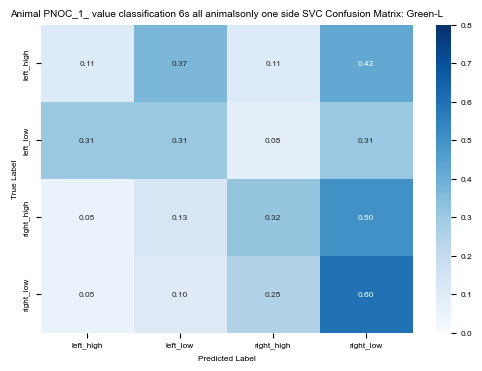

<function accuracy_score at 0x7d6aab314ca0>


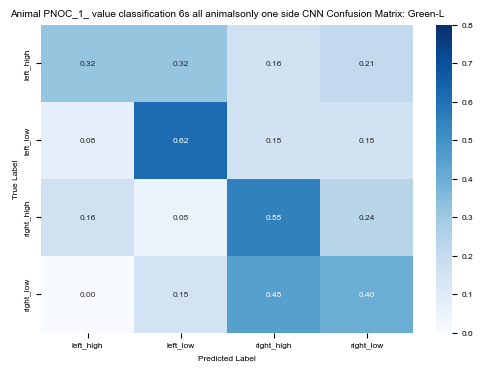

<function accuracy_score at 0x7d6aab314ca0>


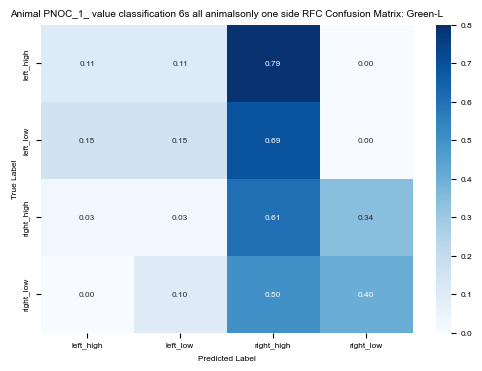

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


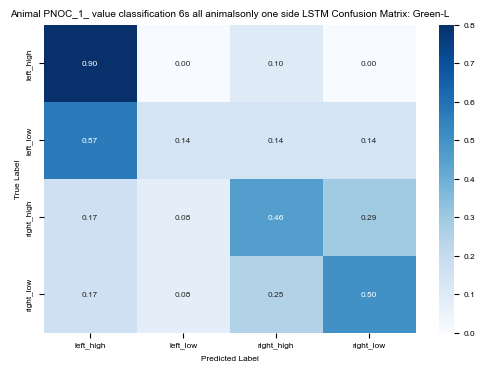


 25%|██▌       | 1/4 [00:48<02:25, 48.52s/it]

X shape: (299, 60)
y shape: (299,)
1
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


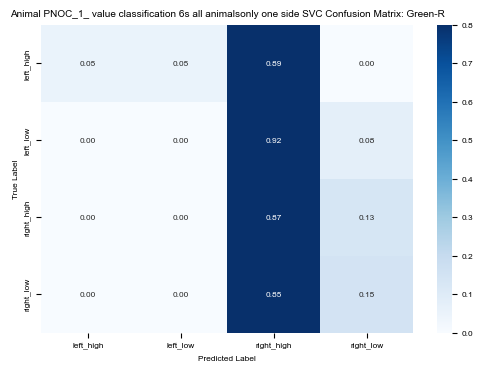

<function accuracy_score at 0x7d6aab314ca0>


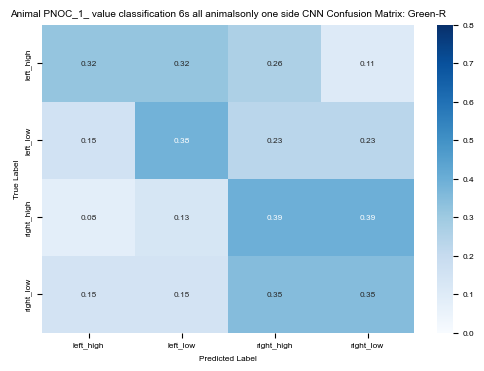

<function accuracy_score at 0x7d6aab314ca0>


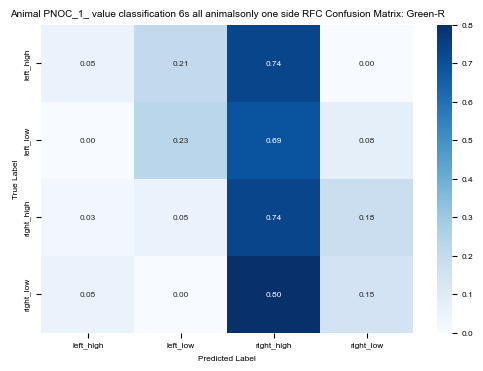

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


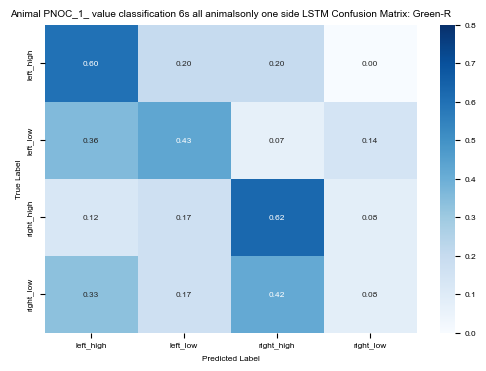


 50%|█████     | 2/4 [01:33<01:33, 46.67s/it]

X shape: (299, 60)
y shape: (299,)
2
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


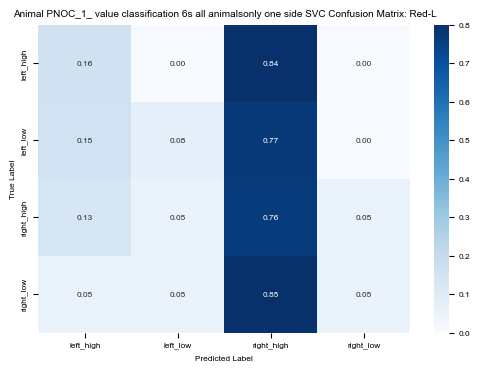

<function accuracy_score at 0x7d6aab314ca0>


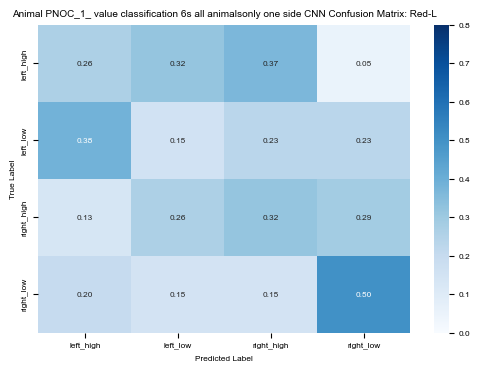

<function accuracy_score at 0x7d6aab314ca0>


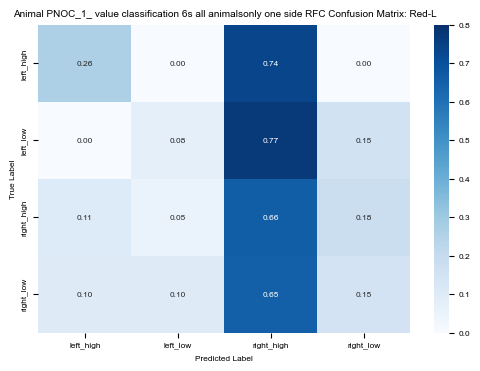

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


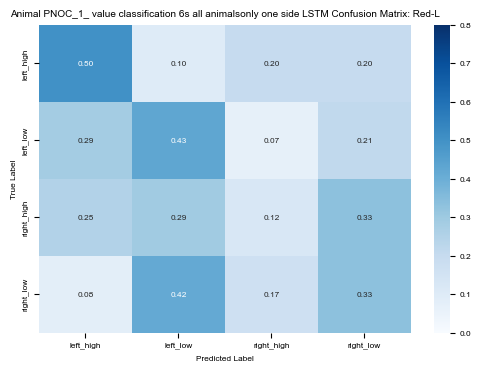


 75%|███████▌  | 3/4 [02:16<00:44, 44.81s/it]

X shape: (299, 60)
y shape: (299,)
3
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


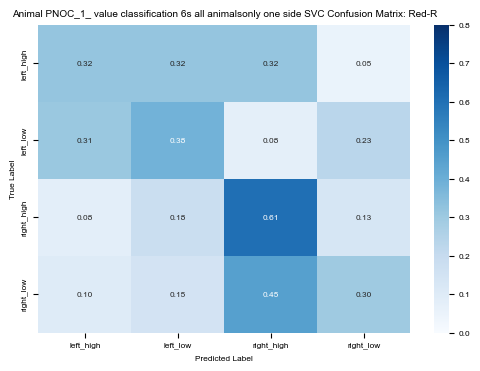

<function accuracy_score at 0x7d6aab314ca0>


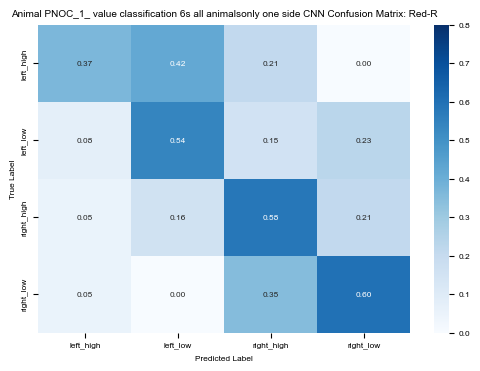

<function accuracy_score at 0x7d6aab314ca0>


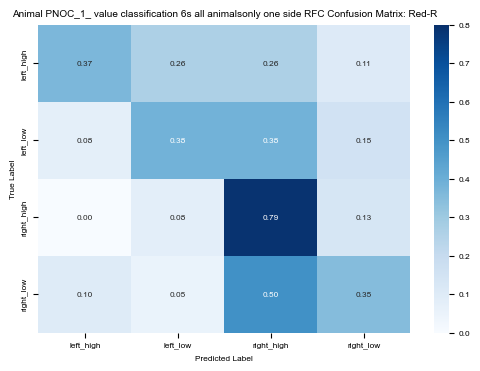

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


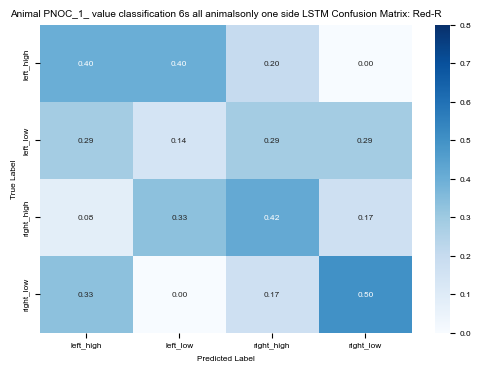


100%|██████████| 4/4 [03:00<00:00, 45.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (204, 60)
y shape: (204,)
0
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


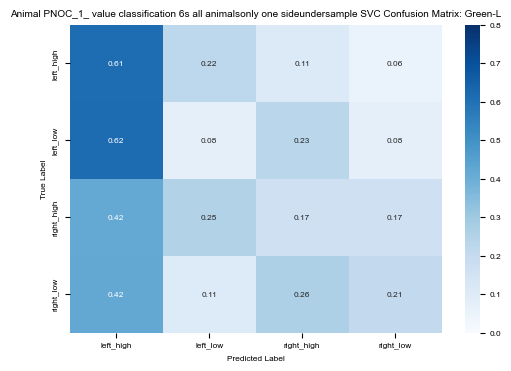

<function accuracy_score at 0x7d6aab314ca0>


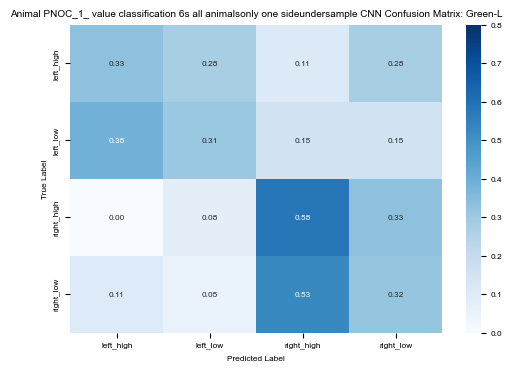

<function accuracy_score at 0x7d6aab314ca0>


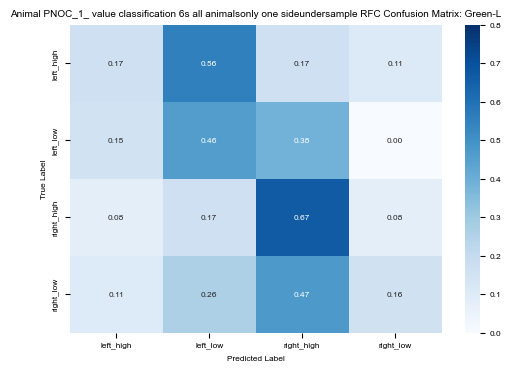

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


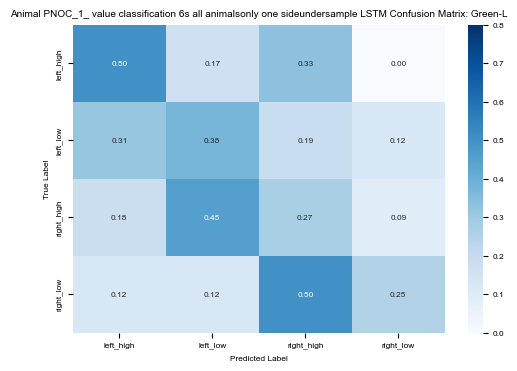


 25%|██▌       | 1/4 [00:38<01:56, 38.70s/it]

X shape: (204, 60)
y shape: (204,)
1
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


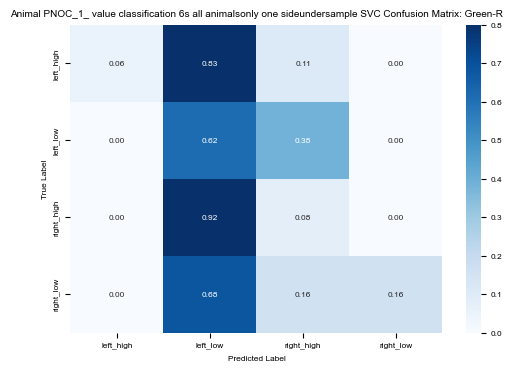

<function accuracy_score at 0x7d6aab314ca0>


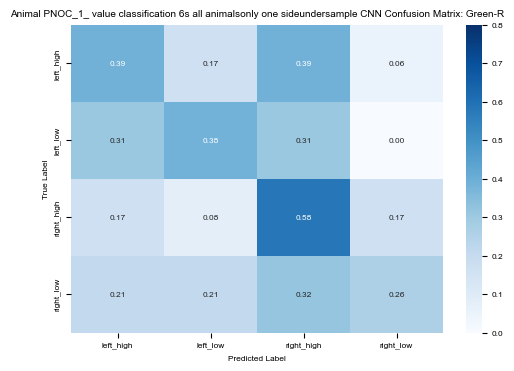

<function accuracy_score at 0x7d6aab314ca0>


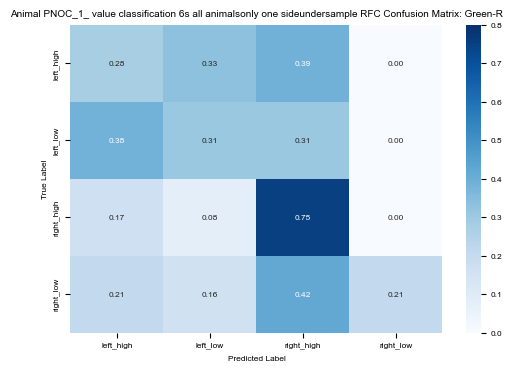

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


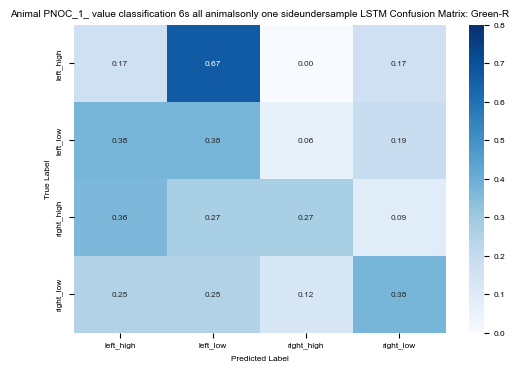


 50%|█████     | 2/4 [01:22<01:22, 41.42s/it]

X shape: (204, 60)
y shape: (204,)
2
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


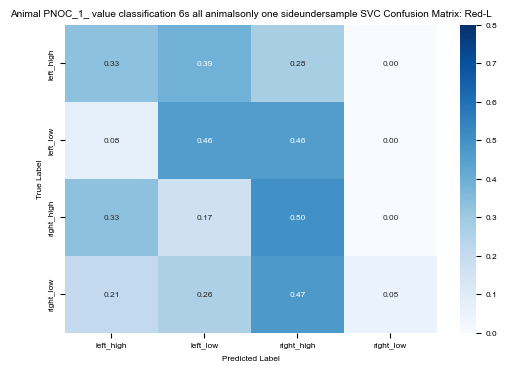

<function accuracy_score at 0x7d6aab314ca0>


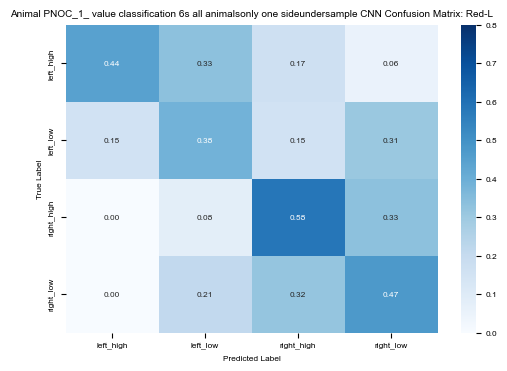

<function accuracy_score at 0x7d6aab314ca0>


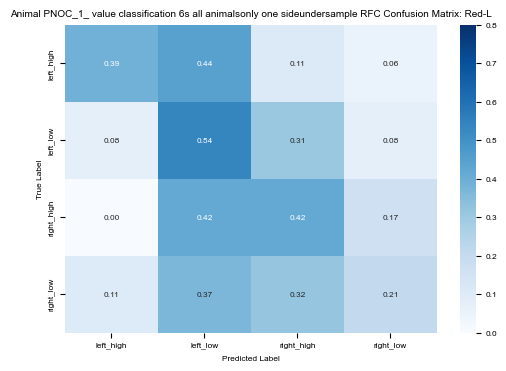

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


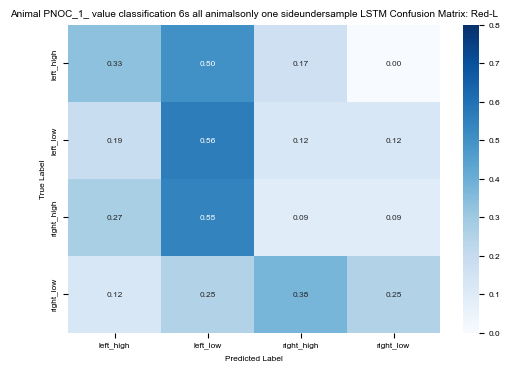


 75%|███████▌  | 3/4 [02:00<00:39, 39.98s/it]

X shape: (204, 60)
y shape: (204,)
3
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


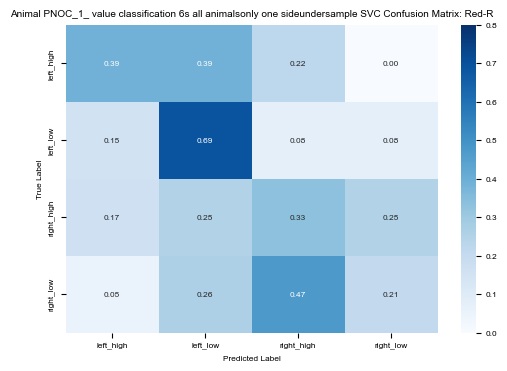

<function accuracy_score at 0x7d6aab314ca0>


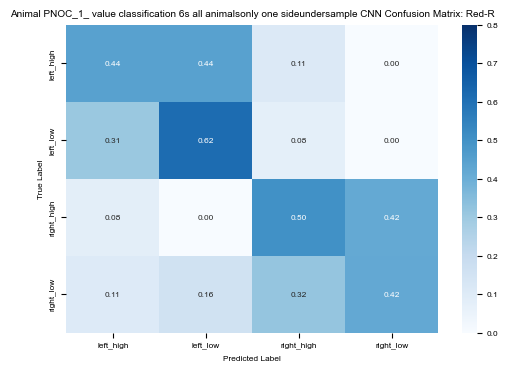

<function accuracy_score at 0x7d6aab314ca0>


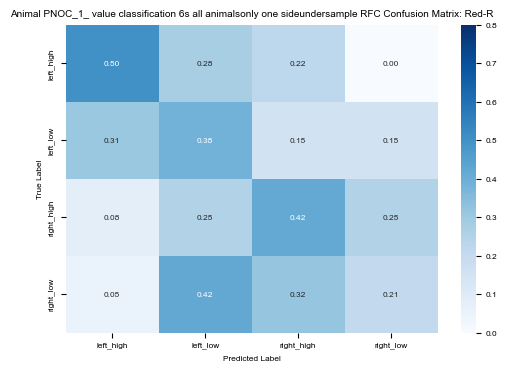

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


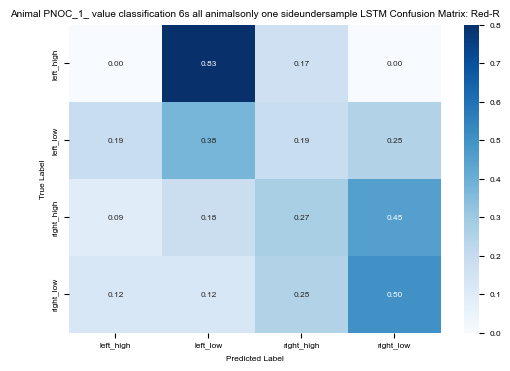


 20%|██        | 1/5 [05:44<22:56, 344.18s/it]

PNOC_2_



100%|██████████| 88/88 [00:00<00:00, 2443.34it/s]

100%|██████████| 88/88 [00:03<00:00, 23.63it/s]

100%|██████████| 88/88 [00:00<00:00, 2187.93it/s]

100%|██████████| 88/88 [00:00<00:00, 2579.34it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (282, 60)
y shape: (282,)
0
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


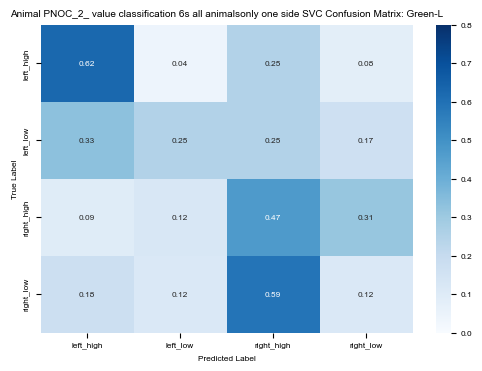

<function accuracy_score at 0x7d6aab314ca0>


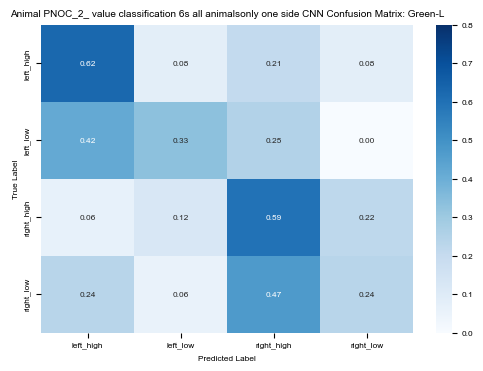

<function accuracy_score at 0x7d6aab314ca0>


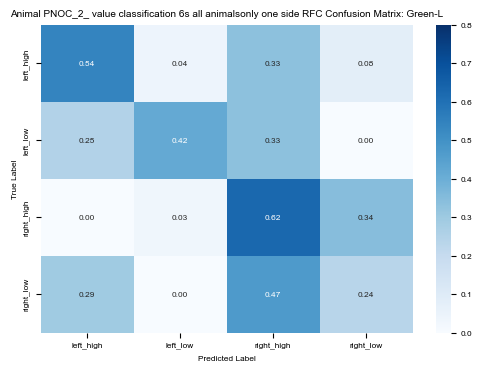

2/2 [==============================] - 1s 7ms/step
<function accuracy_score at 0x7d6aab314ca0>


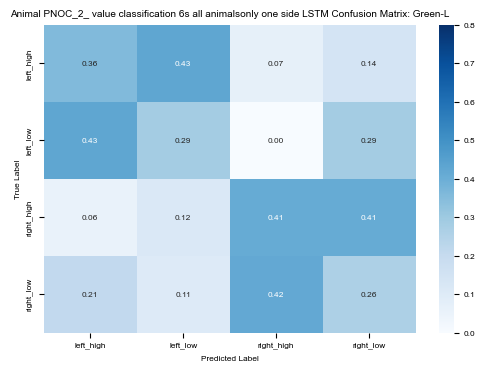


 25%|██▌       | 1/4 [00:46<02:20, 46.76s/it]

X shape: (282, 60)
y shape: (282,)
1
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


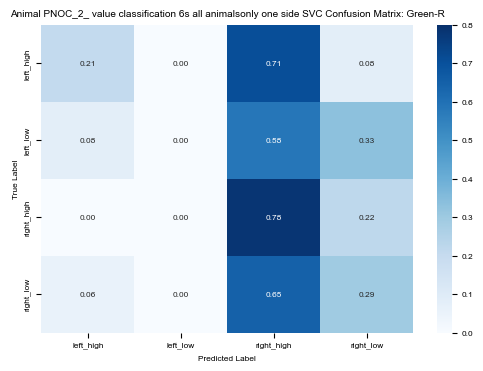

<function accuracy_score at 0x7d6aab314ca0>


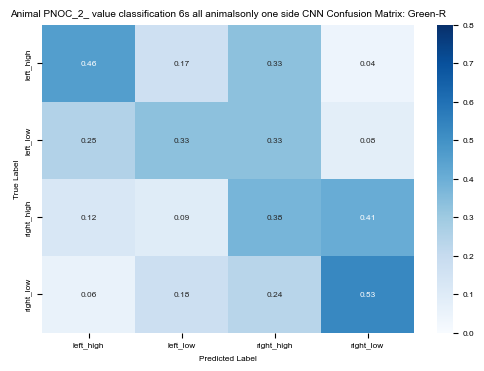

<function accuracy_score at 0x7d6aab314ca0>


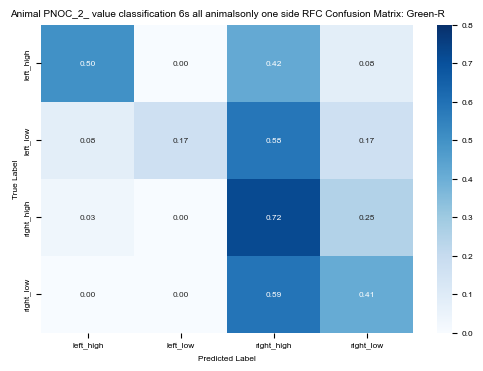

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


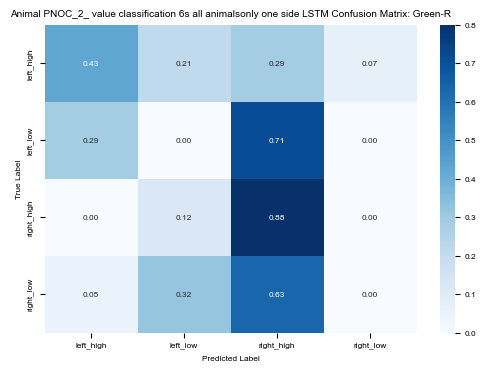


 50%|█████     | 2/4 [01:30<01:29, 44.85s/it]

X shape: (282, 60)
y shape: (282,)
2
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


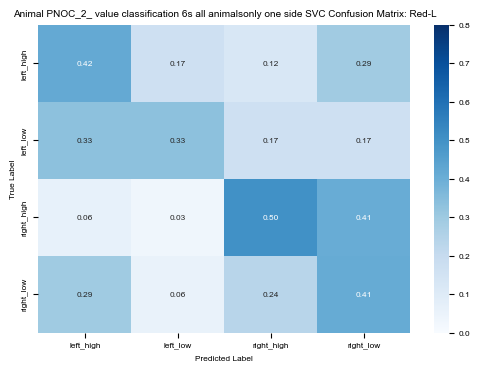

<function accuracy_score at 0x7d6aab314ca0>


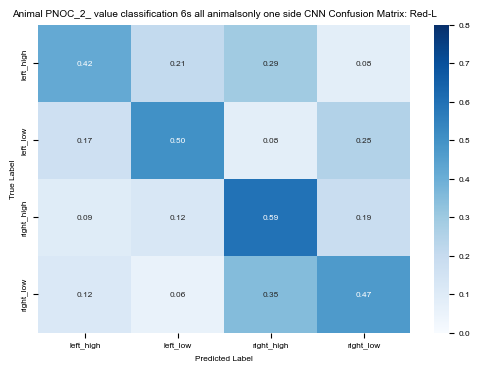

<function accuracy_score at 0x7d6aab314ca0>


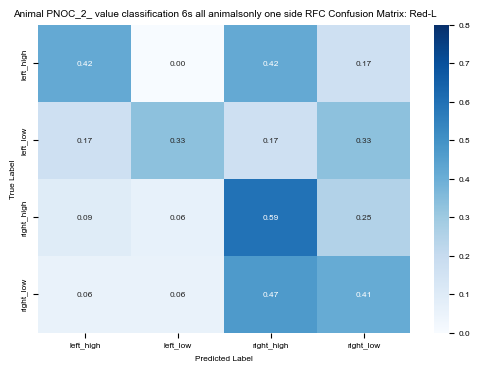

2/2 [==============================] - 1s 7ms/step
<function accuracy_score at 0x7d6aab314ca0>


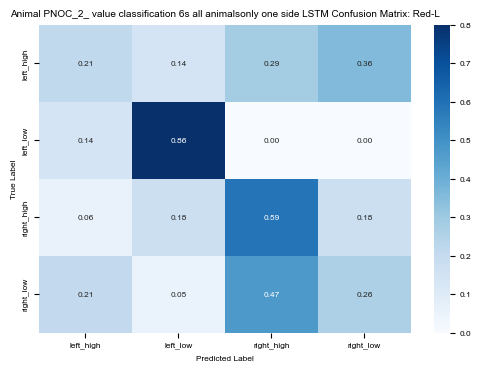


 75%|███████▌  | 3/4 [02:18<00:46, 46.27s/it]

X shape: (282, 60)
y shape: (282,)
3
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


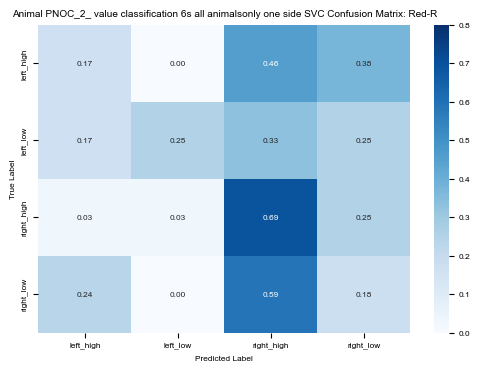

<function accuracy_score at 0x7d6aab314ca0>


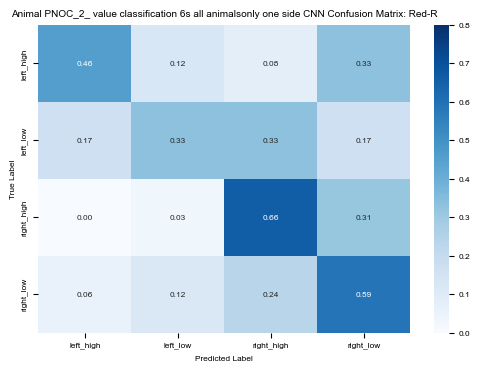

<function accuracy_score at 0x7d6aab314ca0>


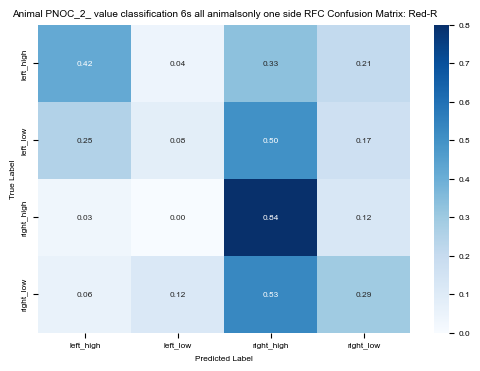

2/2 [==============================] - 1s 7ms/step
<function accuracy_score at 0x7d6aab314ca0>


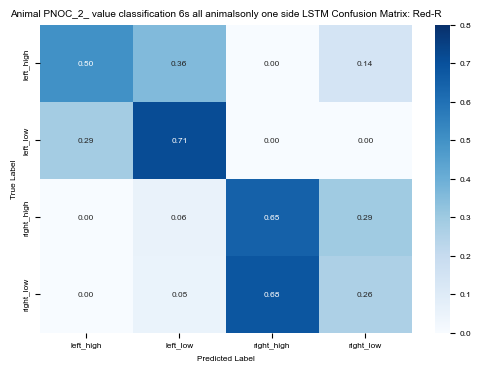


100%|██████████| 4/4 [03:10<00:00, 47.71s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (168, 60)
y shape: (168,)
0
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


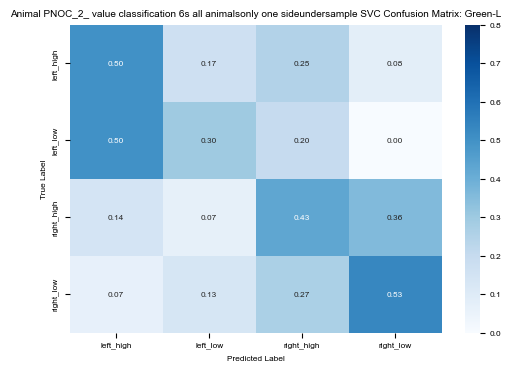

<function accuracy_score at 0x7d6aab314ca0>


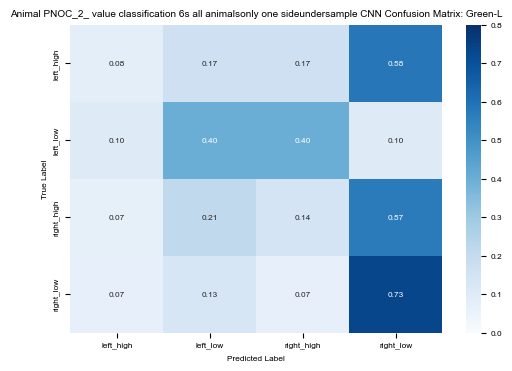

<function accuracy_score at 0x7d6aab314ca0>


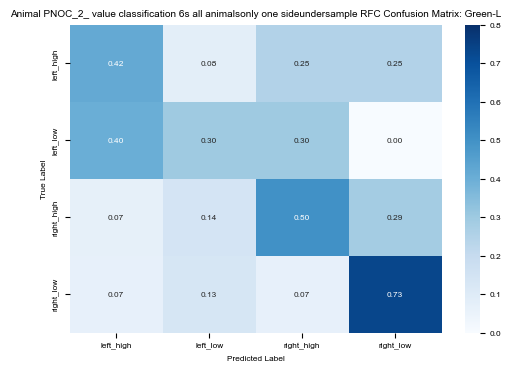

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


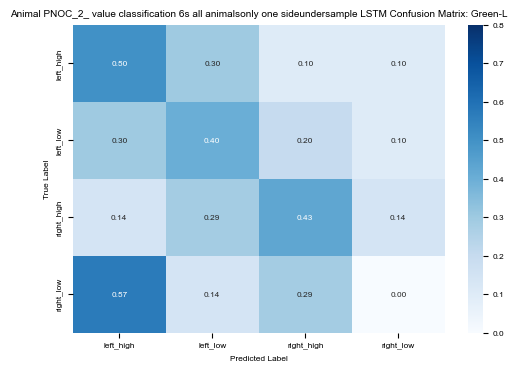


 25%|██▌       | 1/4 [00:33<01:39, 33.24s/it]

X shape: (168, 60)
y shape: (168,)
1
2/2 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


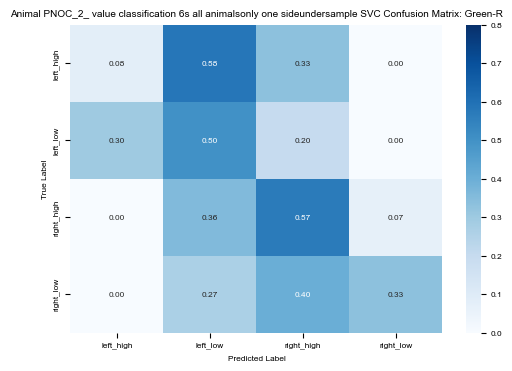

<function accuracy_score at 0x7d6aab314ca0>


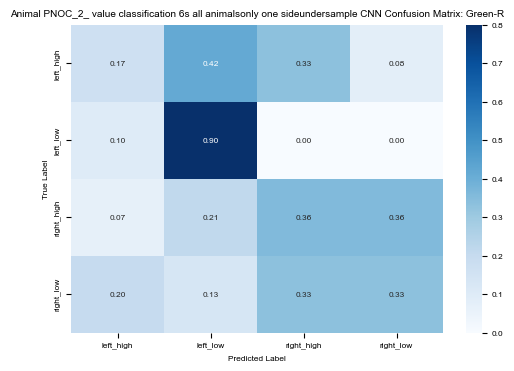

<function accuracy_score at 0x7d6aab314ca0>


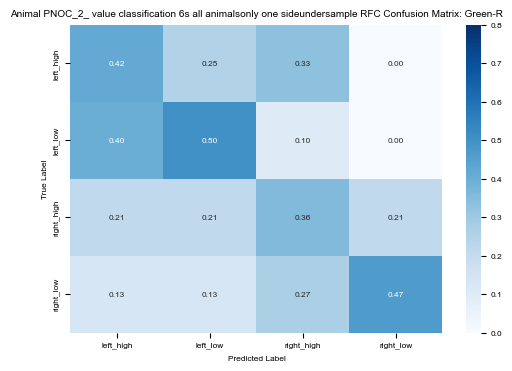

2/2 [==============================] - 1s 7ms/step
<function accuracy_score at 0x7d6aab314ca0>


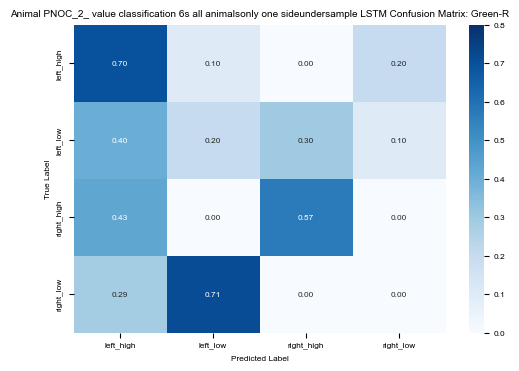


 50%|█████     | 2/4 [01:06<01:06, 33.42s/it]

X shape: (168, 60)
y shape: (168,)
2
2/2 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


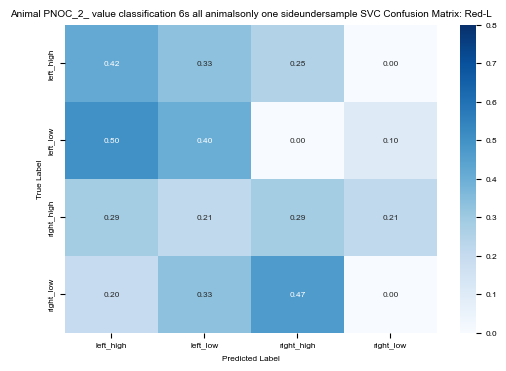

<function accuracy_score at 0x7d6aab314ca0>


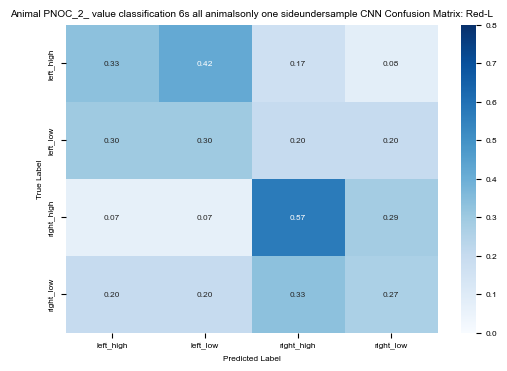

<function accuracy_score at 0x7d6aab314ca0>


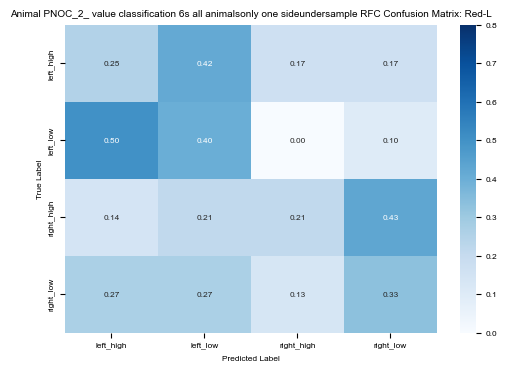

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


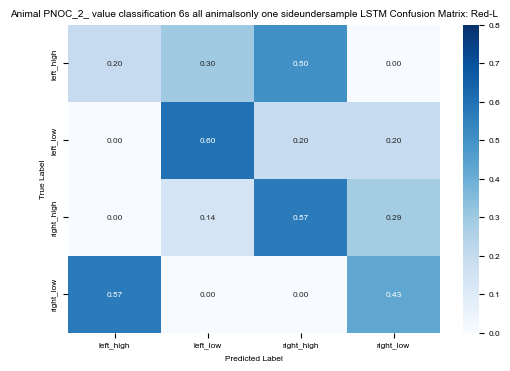


 75%|███████▌  | 3/4 [01:41<00:34, 34.20s/it]

X shape: (168, 60)
y shape: (168,)
3
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


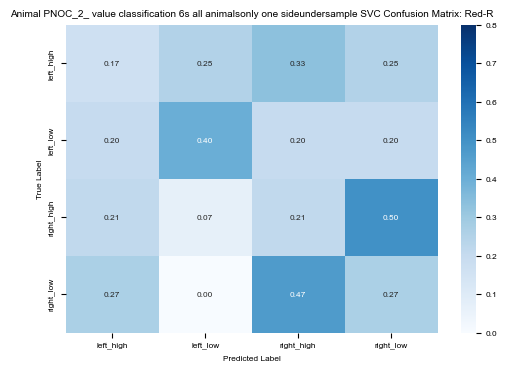

<function accuracy_score at 0x7d6aab314ca0>


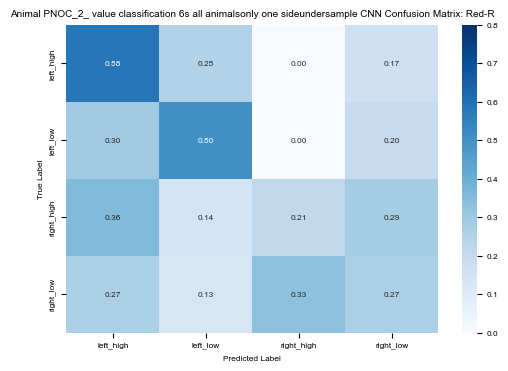

<function accuracy_score at 0x7d6aab314ca0>


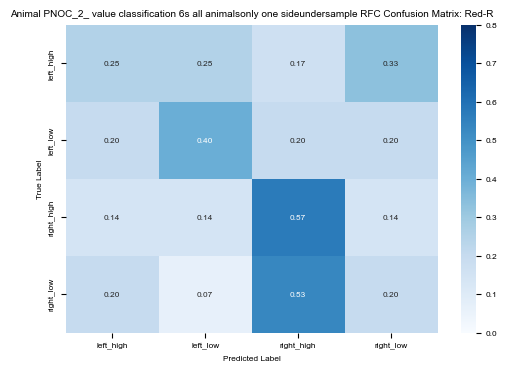

2/2 [==============================] - 1s 7ms/step
<function accuracy_score at 0x7d6aab314ca0>


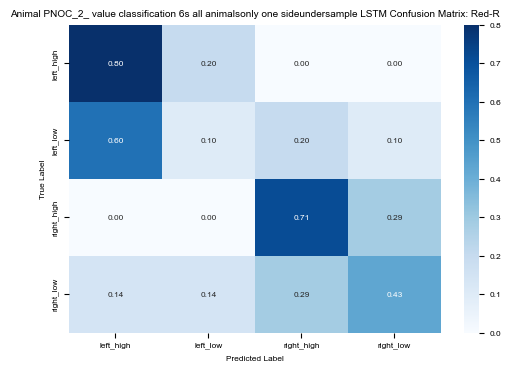


 40%|████      | 2/5 [11:19<16:56, 338.98s/it]

PNOC_3_



100%|██████████| 88/88 [00:00<00:00, 2260.42it/s]

100%|██████████| 88/88 [00:03<00:00, 23.84it/s]

100%|██████████| 88/88 [00:00<00:00, 2335.93it/s]

100%|██████████| 88/88 [00:00<00:00, 2223.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (130, 60)
y shape: (130,)
0
2/2 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


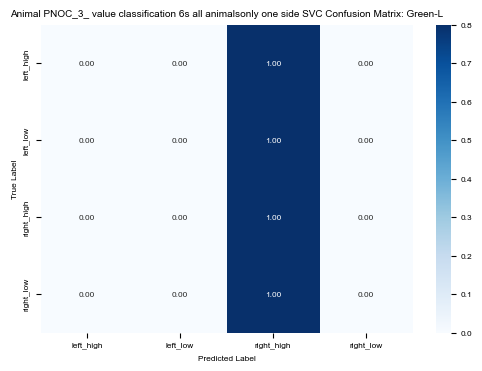

<function accuracy_score at 0x7d6aab314ca0>


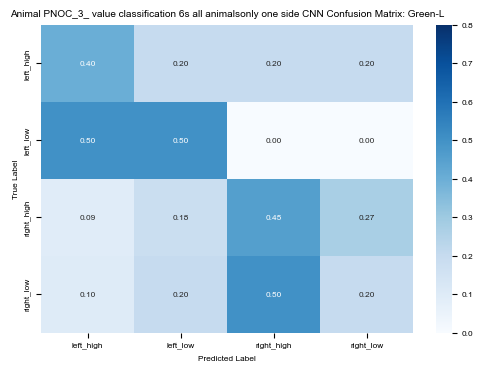

<function accuracy_score at 0x7d6aab314ca0>


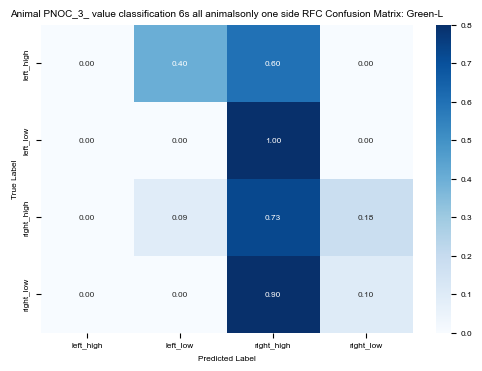

1/1 [==============================] - 1s 626ms/step
<function accuracy_score at 0x7d6aab314ca0>


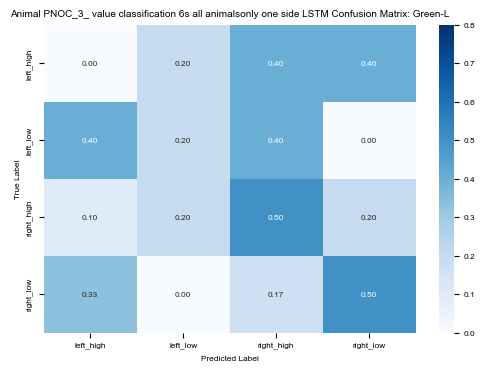


 25%|██▌       | 1/4 [00:31<01:34, 31.61s/it]

X shape: (130, 60)
y shape: (130,)
1
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


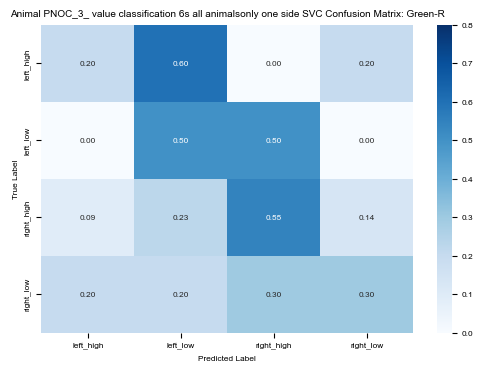

<function accuracy_score at 0x7d6aab314ca0>


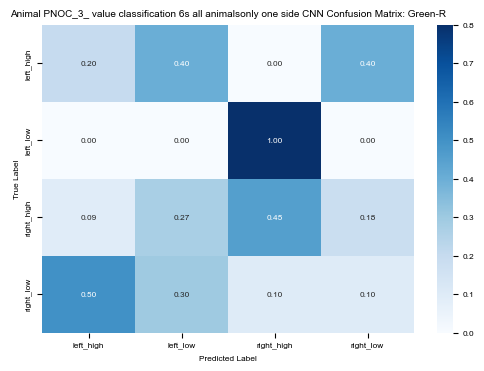

<function accuracy_score at 0x7d6aab314ca0>


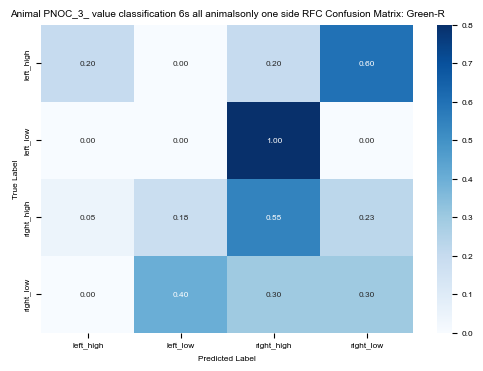

1/1 [==============================] - 1s 614ms/step
<function accuracy_score at 0x7d6aab314ca0>


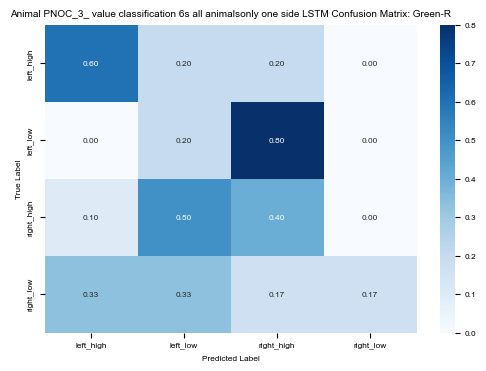


 50%|█████     | 2/4 [01:05<01:05, 32.73s/it]

X shape: (130, 60)
y shape: (130,)
2
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


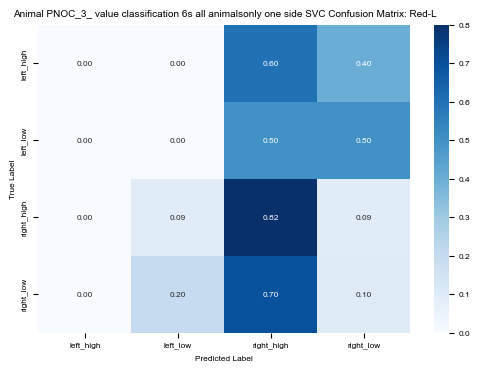

<function accuracy_score at 0x7d6aab314ca0>


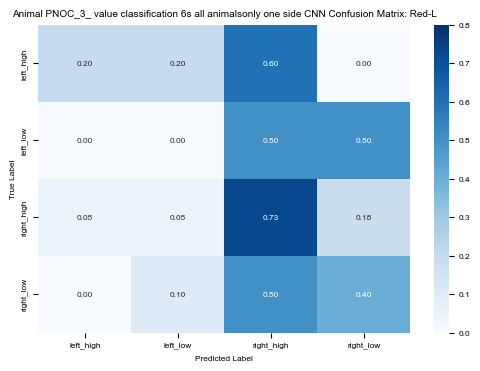

<function accuracy_score at 0x7d6aab314ca0>


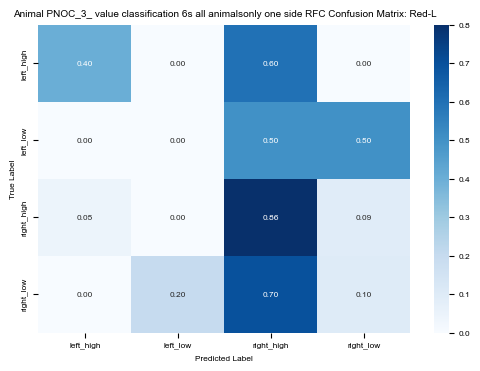

1/1 [==============================] - 1s 602ms/step
<function accuracy_score at 0x7d6aab314ca0>


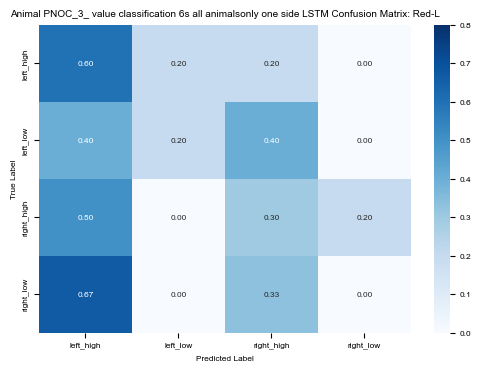


 75%|███████▌  | 3/4 [01:36<00:32, 32.20s/it]

X shape: (130, 60)
y shape: (130,)
3
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


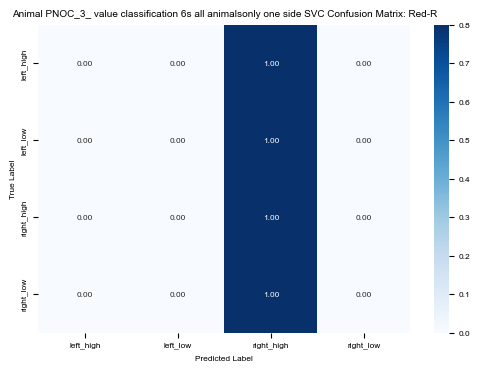

<function accuracy_score at 0x7d6aab314ca0>


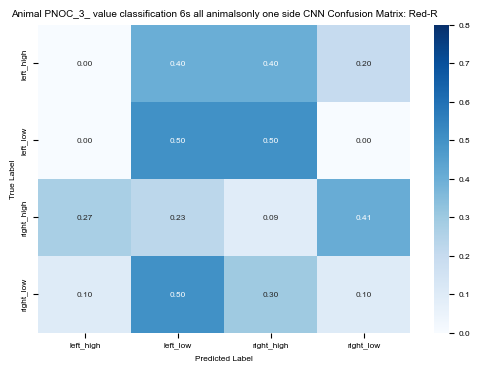

<function accuracy_score at 0x7d6aab314ca0>


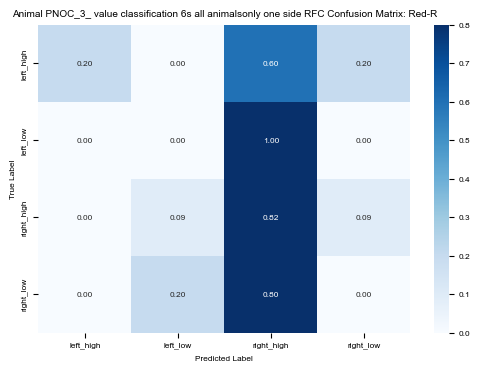

1/1 [==============================] - 1s 598ms/step
<function accuracy_score at 0x7d6aab314ca0>


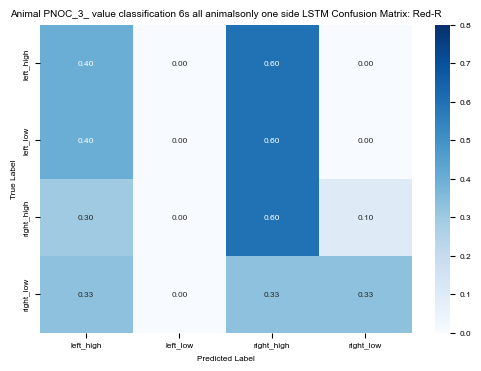


100%|██████████| 4/4 [02:10<00:00, 32.65s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (80, 60)
y shape: (80,)
0
1/1 [==============================] - 0s 64ms/step
<function accuracy_score at 0x7d6aab314ca0>


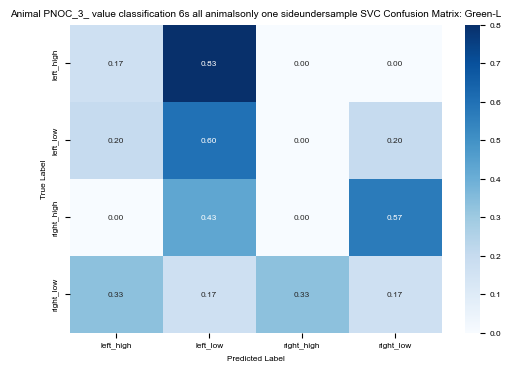

<function accuracy_score at 0x7d6aab314ca0>


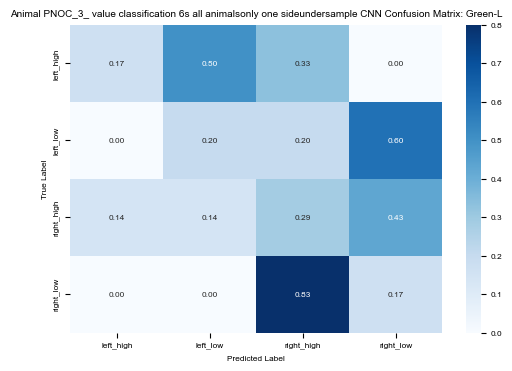

<function accuracy_score at 0x7d6aab314ca0>


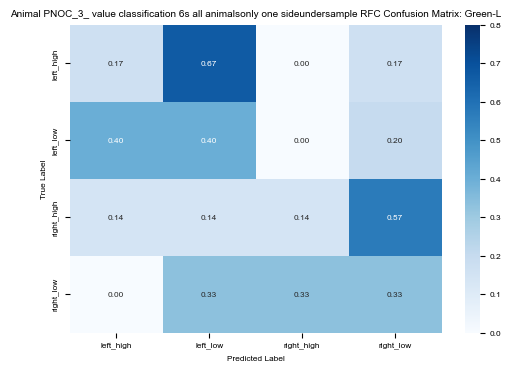

1/1 [==============================] - 1s 589ms/step
<function accuracy_score at 0x7d6aab314ca0>


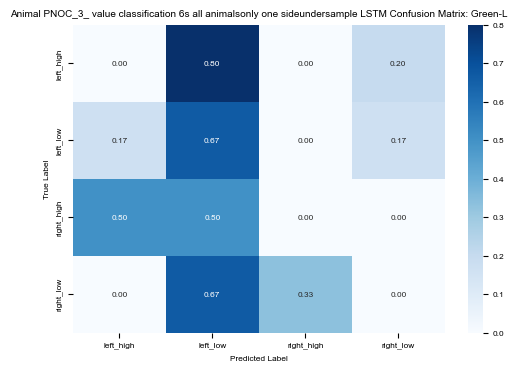


 25%|██▌       | 1/4 [00:27<01:22, 27.51s/it]

X shape: (80, 60)
y shape: (80,)
1
1/1 [==============================] - 0s 77ms/step
<function accuracy_score at 0x7d6aab314ca0>


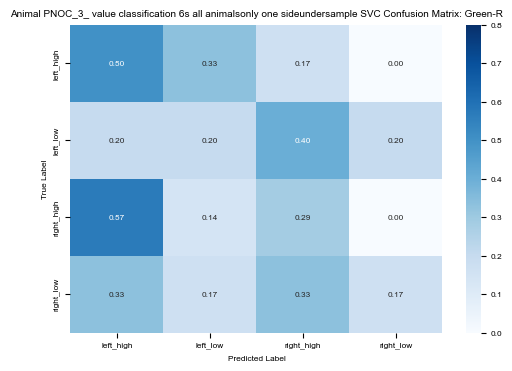

<function accuracy_score at 0x7d6aab314ca0>


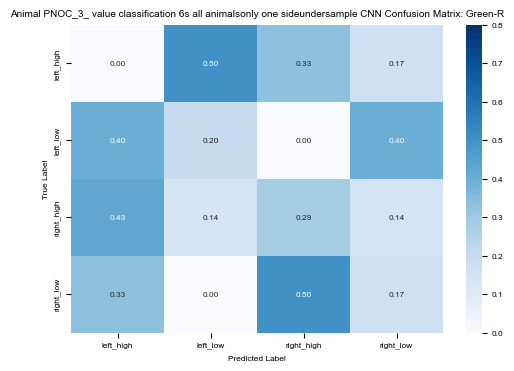

<function accuracy_score at 0x7d6aab314ca0>


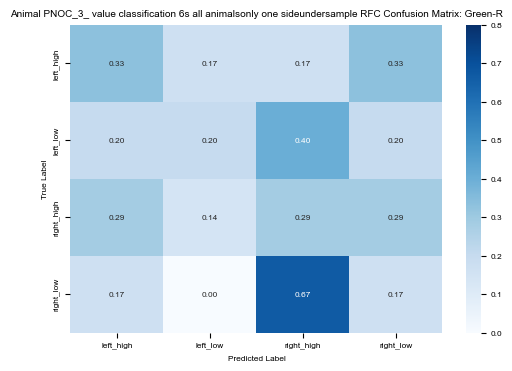

1/1 [==============================] - 1s 636ms/step
<function accuracy_score at 0x7d6aab314ca0>


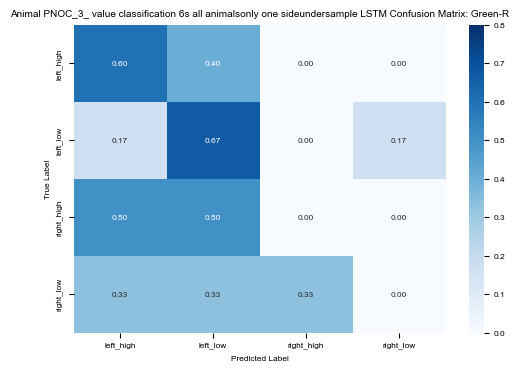


 50%|█████     | 2/4 [00:56<00:56, 28.13s/it]

X shape: (80, 60)
y shape: (80,)
2
1/1 [==============================] - 0s 66ms/step
<function accuracy_score at 0x7d6aab314ca0>


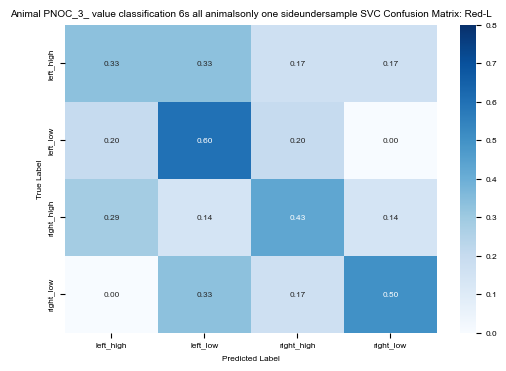

<function accuracy_score at 0x7d6aab314ca0>


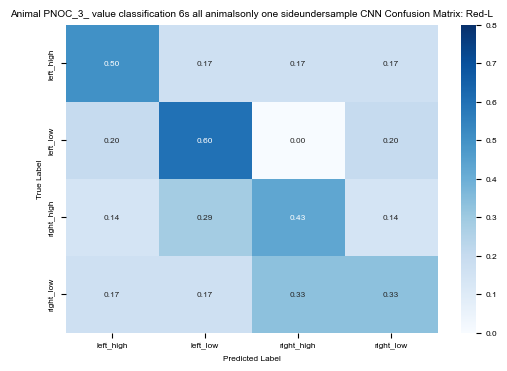

<function accuracy_score at 0x7d6aab314ca0>


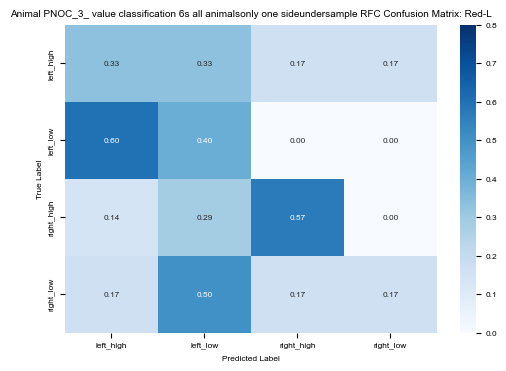

1/1 [==============================] - 1s 631ms/step
<function accuracy_score at 0x7d6aab314ca0>


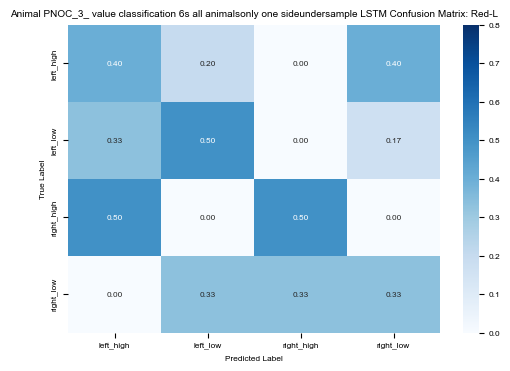


 75%|███████▌  | 3/4 [01:23<00:27, 27.63s/it]

X shape: (80, 60)
y shape: (80,)
3
1/1 [==============================] - 0s 70ms/step
<function accuracy_score at 0x7d6aab314ca0>


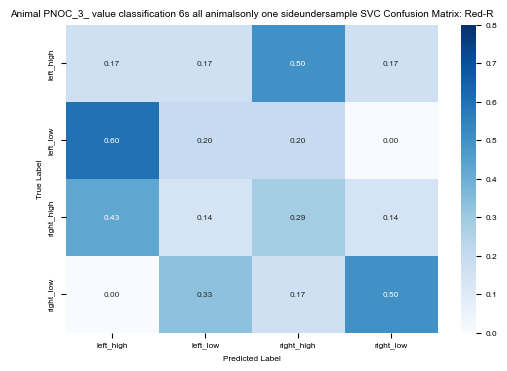

<function accuracy_score at 0x7d6aab314ca0>


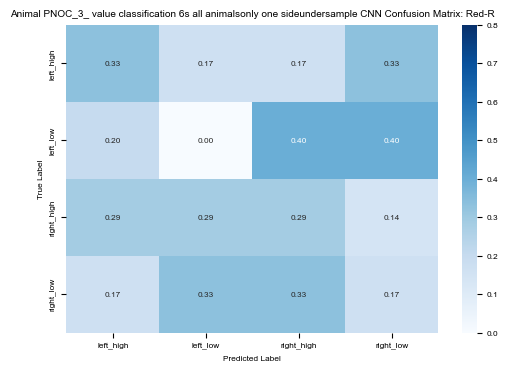

<function accuracy_score at 0x7d6aab314ca0>


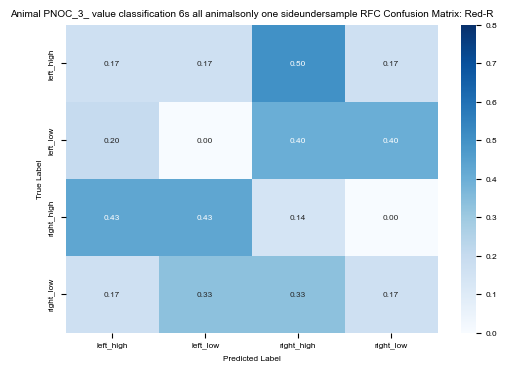

1/1 [==============================] - 1s 595ms/step
<function accuracy_score at 0x7d6aab314ca0>


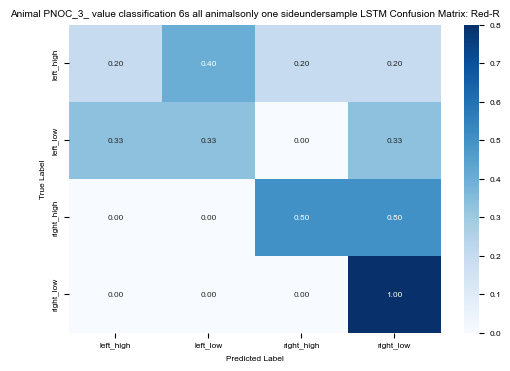


 60%|██████    | 3/5 [15:25<09:53, 296.51s/it]

PNOC_4_



100%|██████████| 112/112 [00:03<00:00, 32.07it/s]

100%|██████████| 112/112 [00:00<00:00, 1944.71it/s]

100%|██████████| 112/112 [00:00<00:00, 2603.73it/s]

100%|██████████| 112/112 [00:00<00:00, 2664.26it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (374, 60)
y shape: (374,)
0
4/4 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


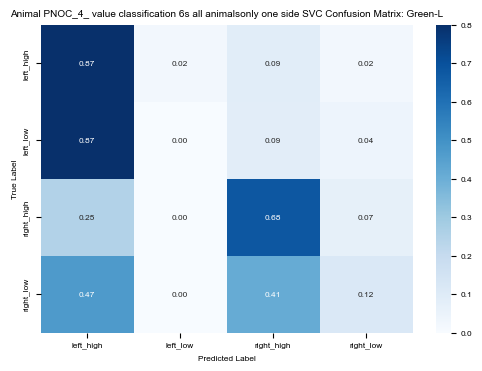

<function accuracy_score at 0x7d6aab314ca0>


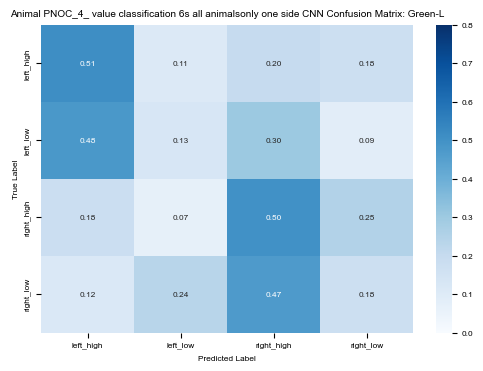

<function accuracy_score at 0x7d6aab314ca0>


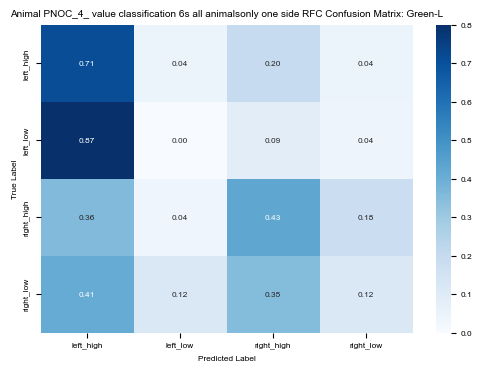

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


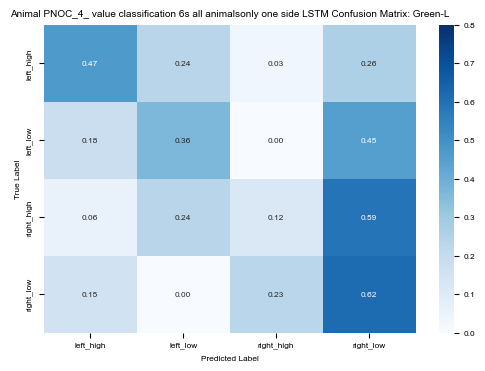


 25%|██▌       | 1/4 [00:54<02:44, 54.75s/it]

X shape: (374, 60)
y shape: (374,)
1
4/4 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


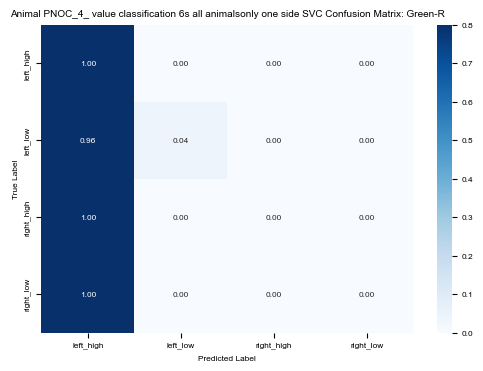

<function accuracy_score at 0x7d6aab314ca0>


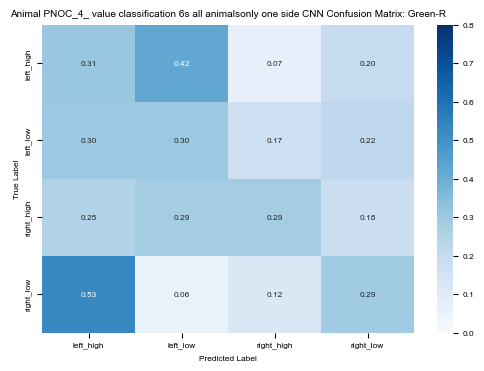

<function accuracy_score at 0x7d6aab314ca0>


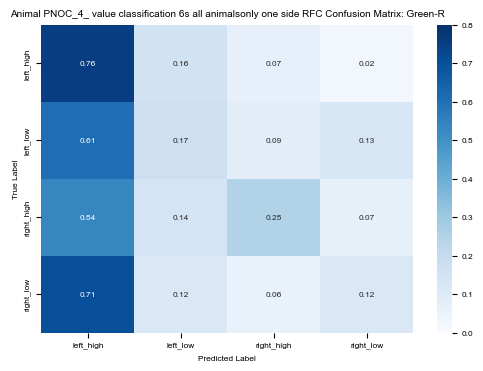

3/3 [==============================] - 5s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


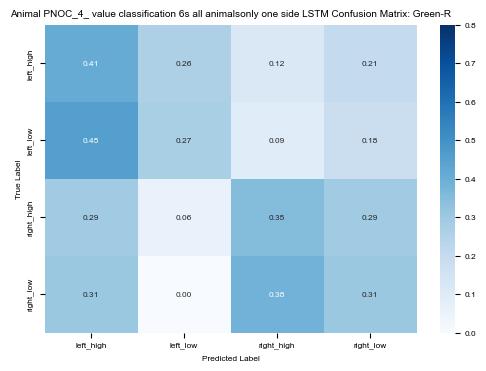


 50%|█████     | 2/4 [01:51<01:51, 55.83s/it]

X shape: (374, 60)
y shape: (374,)
2
4/4 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


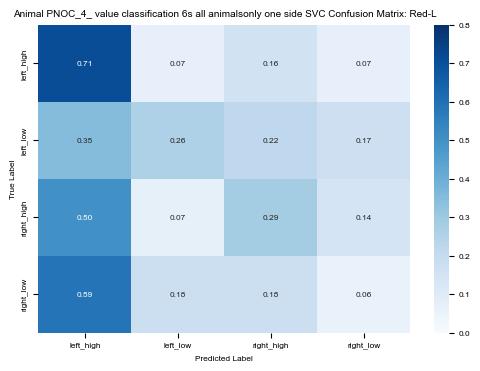

<function accuracy_score at 0x7d6aab314ca0>


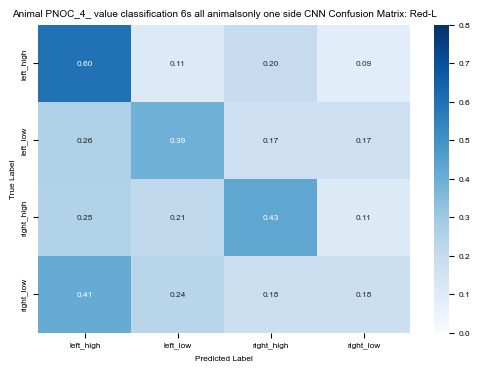

<function accuracy_score at 0x7d6aab314ca0>


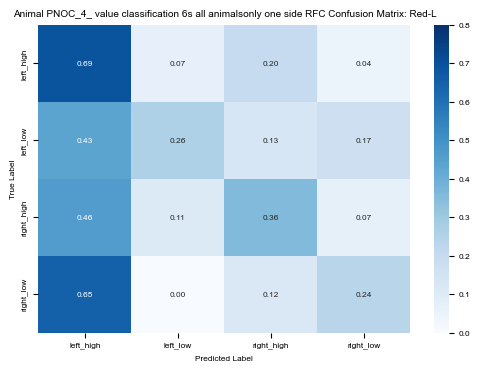

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


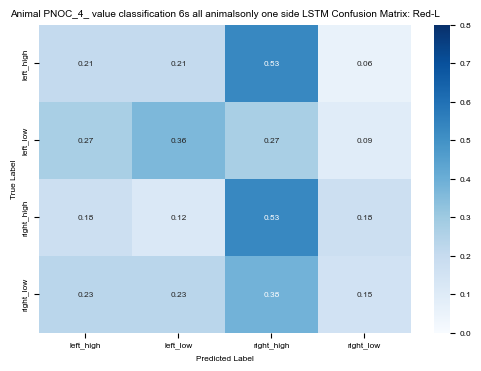


 75%|███████▌  | 3/4 [02:43<00:53, 53.95s/it]

X shape: (374, 60)
y shape: (374,)
3
4/4 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


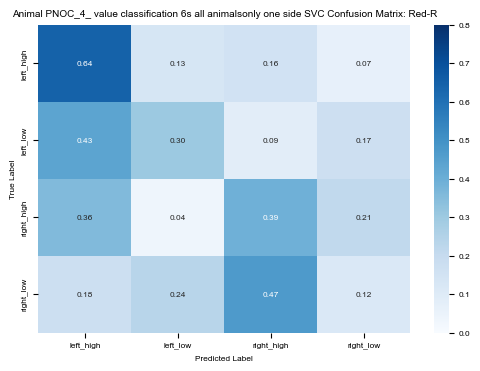

<function accuracy_score at 0x7d6aab314ca0>


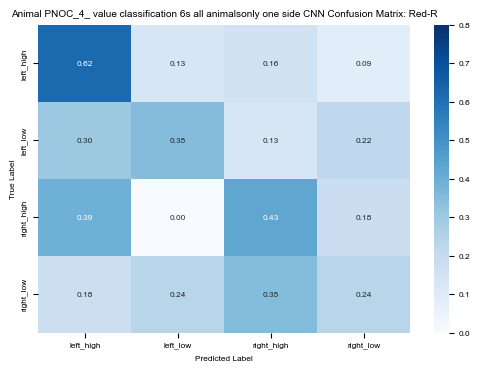

<function accuracy_score at 0x7d6aab314ca0>


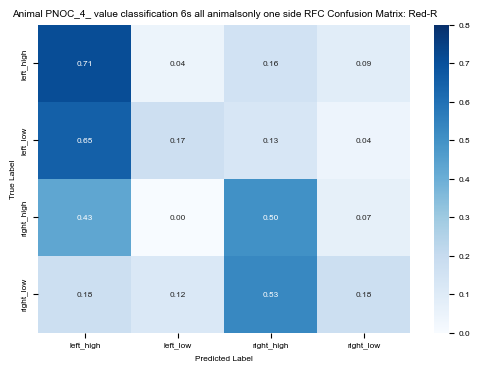

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


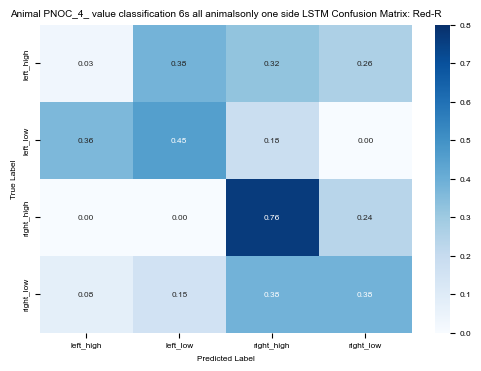


100%|██████████| 4/4 [03:33<00:00, 53.35s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (276, 60)
y shape: (276,)
0
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


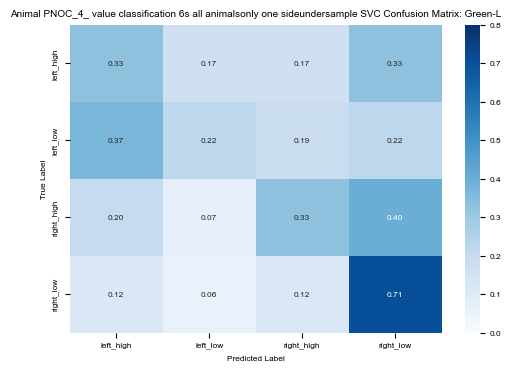

<function accuracy_score at 0x7d6aab314ca0>


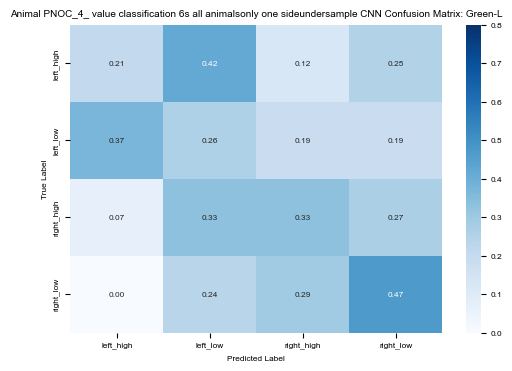

<function accuracy_score at 0x7d6aab314ca0>


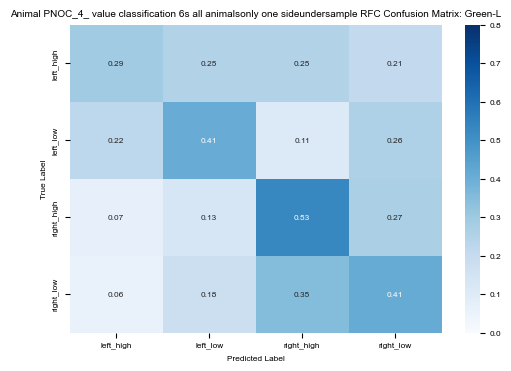

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


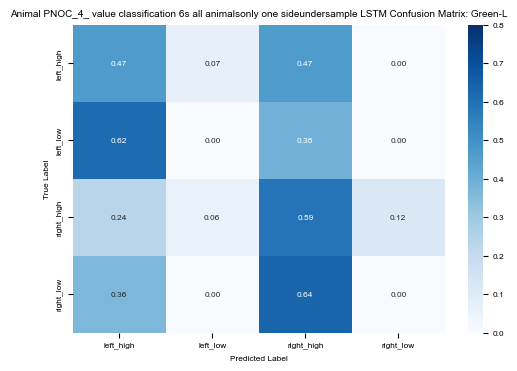


 25%|██▌       | 1/4 [00:44<02:12, 44.32s/it]

X shape: (276, 60)
y shape: (276,)
1
3/3 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


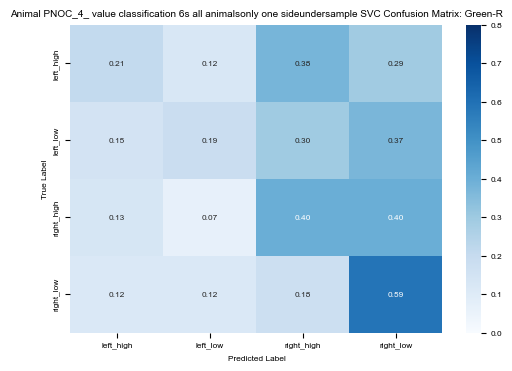

<function accuracy_score at 0x7d6aab314ca0>


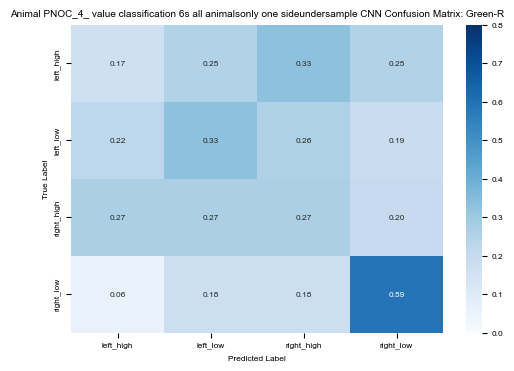

<function accuracy_score at 0x7d6aab314ca0>


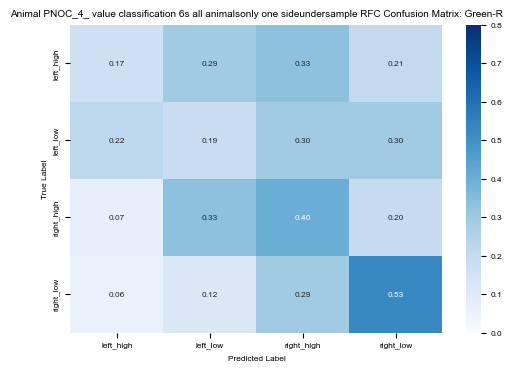

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


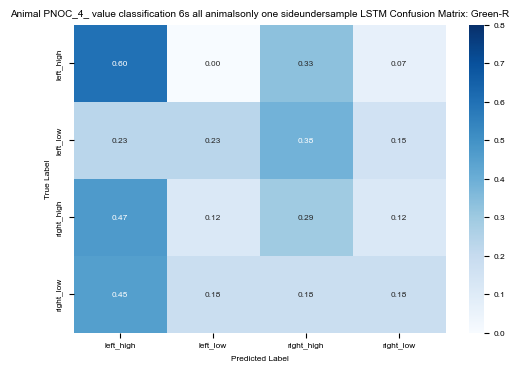


 50%|█████     | 2/4 [01:26<01:25, 42.93s/it]

X shape: (276, 60)
y shape: (276,)
2
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


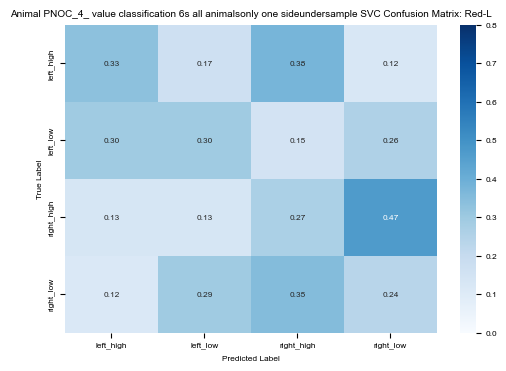

<function accuracy_score at 0x7d6aab314ca0>


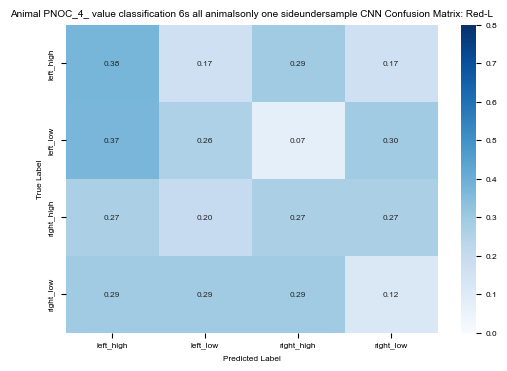

<function accuracy_score at 0x7d6aab314ca0>


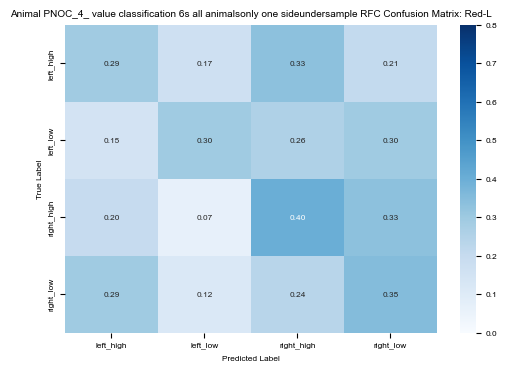

2/2 [==============================] - 1s 7ms/step
<function accuracy_score at 0x7d6aab314ca0>


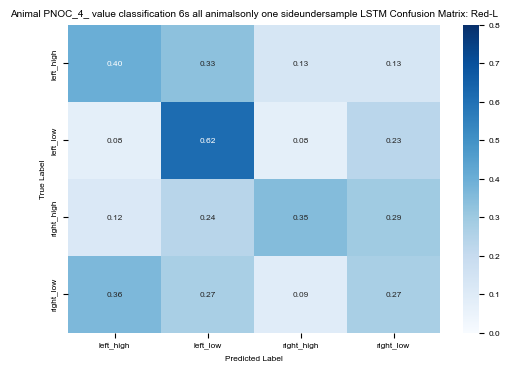


 75%|███████▌  | 3/4 [02:10<00:43, 43.33s/it]

X shape: (276, 60)
y shape: (276,)
3
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


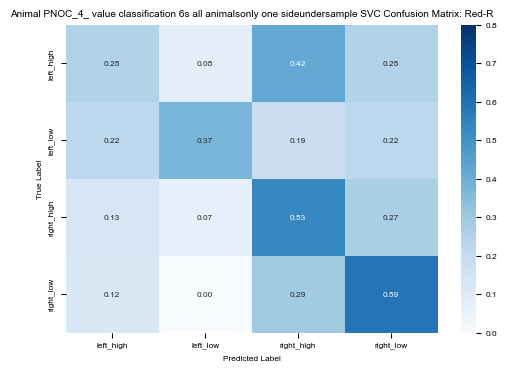

<function accuracy_score at 0x7d6aab314ca0>


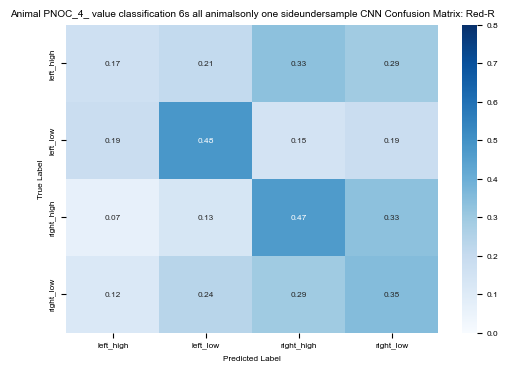

<function accuracy_score at 0x7d6aab314ca0>


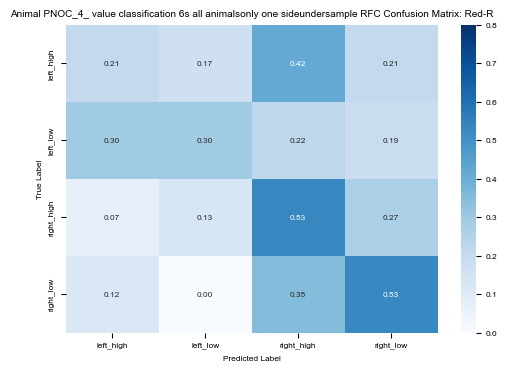

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


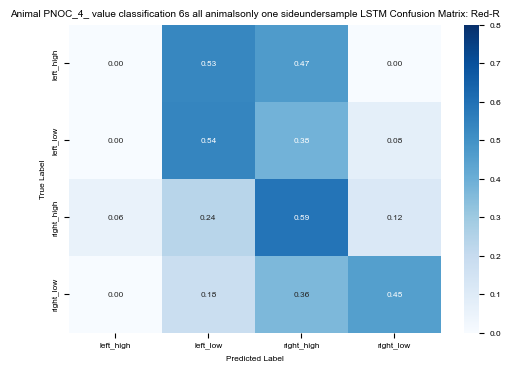


 80%|████████  | 4/5 [21:54<05:33, 333.18s/it]

PNOC_5_



100%|██████████| 72/72 [00:00<00:00, 1428.63it/s]

100%|██████████| 72/72 [00:03<00:00, 19.58it/s]

100%|██████████| 72/72 [00:00<00:00, 2318.58it/s]

100%|██████████| 72/72 [00:00<00:00, 1324.55it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (132, 60)
y shape: (132,)
0
2/2 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


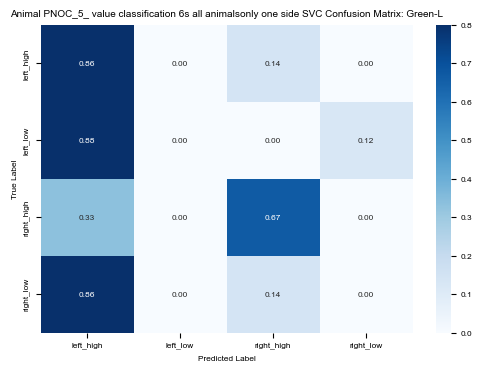

<function accuracy_score at 0x7d6aab314ca0>


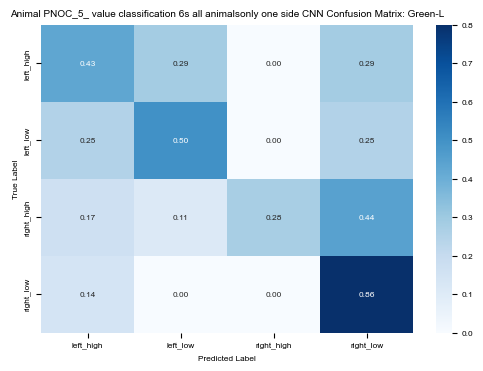

<function accuracy_score at 0x7d6aab314ca0>


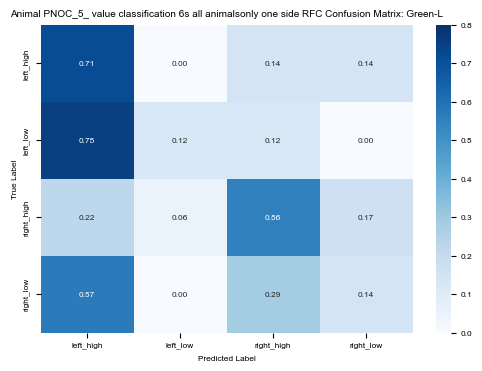

1/1 [==============================] - 1s 632ms/step
<function accuracy_score at 0x7d6aab314ca0>


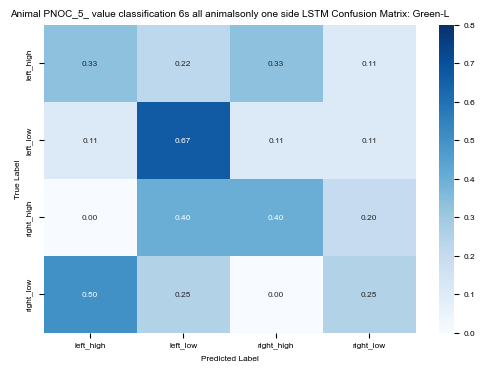


 25%|██▌       | 1/4 [00:33<01:41, 33.71s/it]

X shape: (132, 60)
y shape: (132,)
1
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


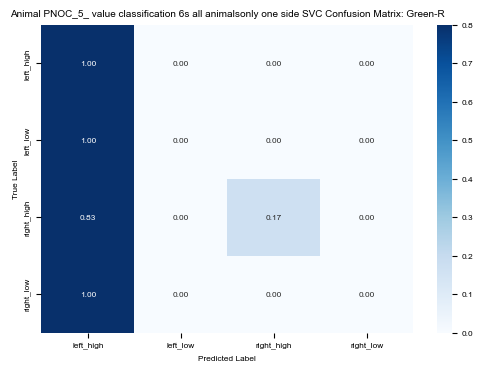

<function accuracy_score at 0x7d6aab314ca0>


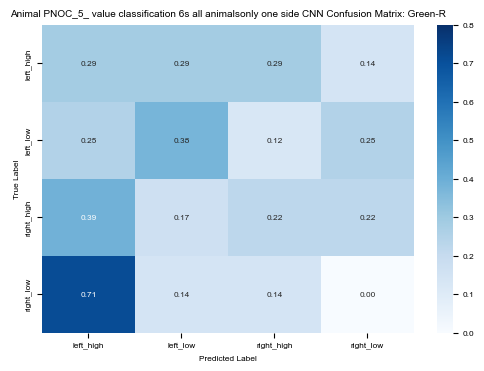

<function accuracy_score at 0x7d6aab314ca0>


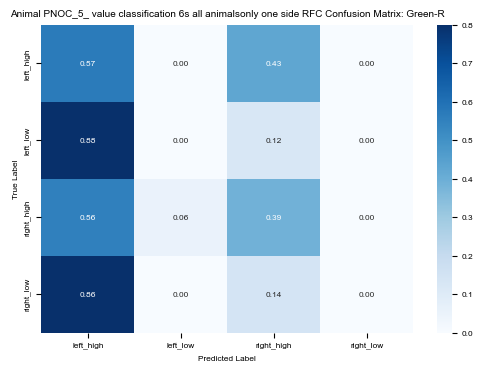

1/1 [==============================] - 1s 642ms/step
<function accuracy_score at 0x7d6aab314ca0>


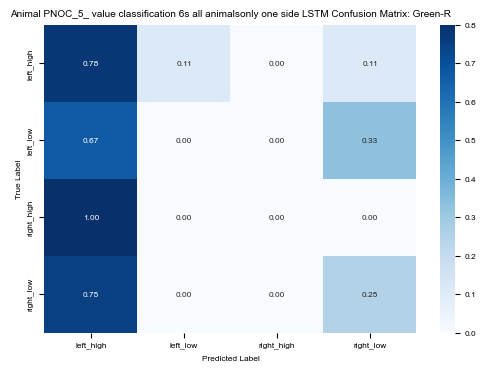


 50%|█████     | 2/4 [01:04<01:03, 31.95s/it]

X shape: (132, 60)
y shape: (132,)
2
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


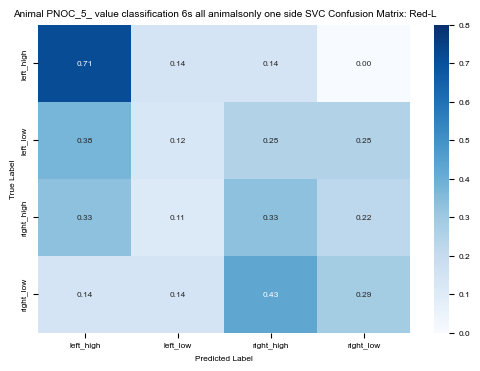

<function accuracy_score at 0x7d6aab314ca0>


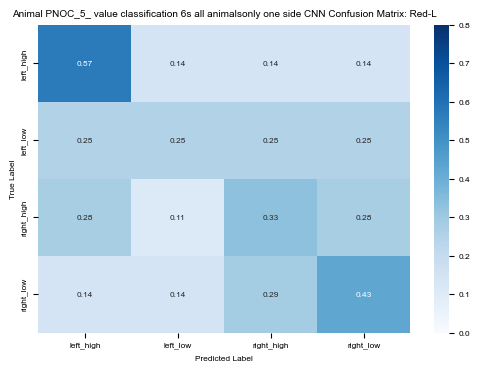

<function accuracy_score at 0x7d6aab314ca0>


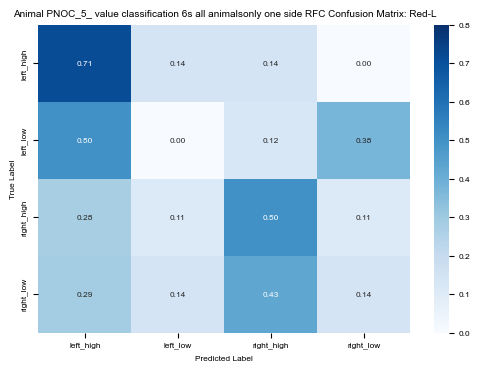

1/1 [==============================] - 1s 600ms/step
<function accuracy_score at 0x7d6aab314ca0>


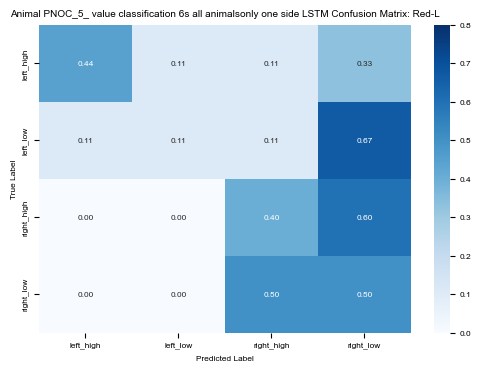


 75%|███████▌  | 3/4 [01:35<00:31, 31.59s/it]

X shape: (132, 60)
y shape: (132,)
3
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


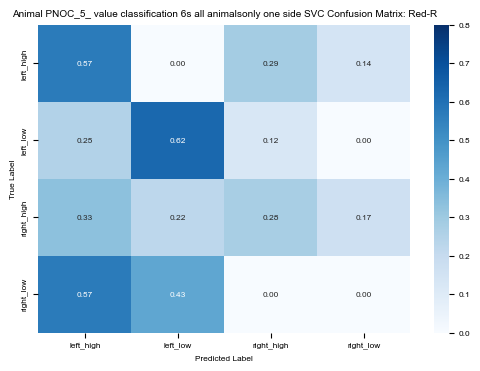

<function accuracy_score at 0x7d6aab314ca0>


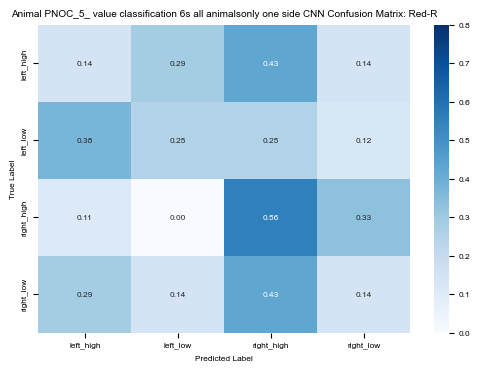

<function accuracy_score at 0x7d6aab314ca0>


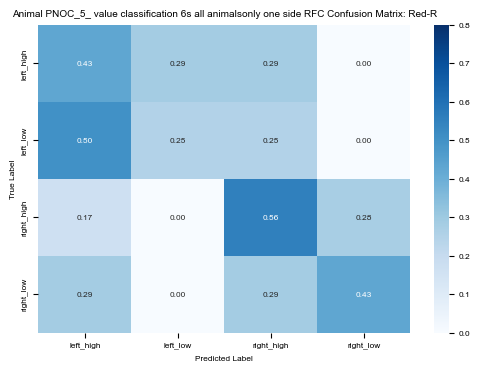

1/1 [==============================] - 1s 599ms/step
<function accuracy_score at 0x7d6aab314ca0>


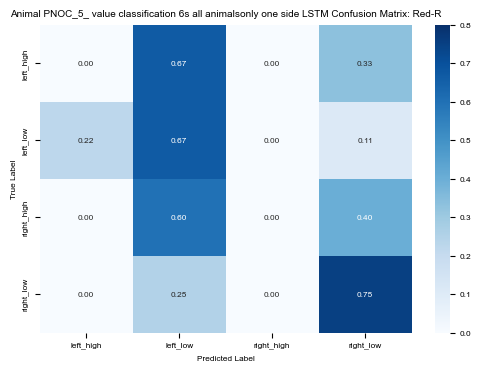


100%|██████████| 4/4 [02:08<00:00, 32.02s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (100, 60)
y shape: (100,)
0
1/1 [==============================] - 0s 63ms/step
<function accuracy_score at 0x7d6aab314ca0>


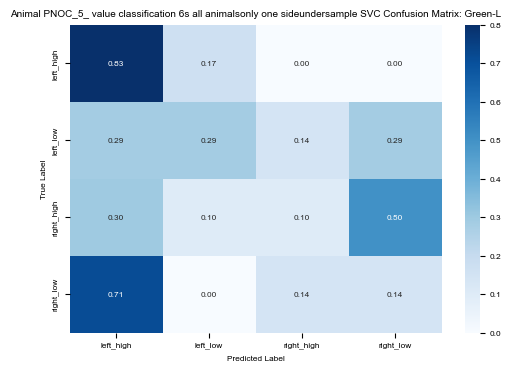

<function accuracy_score at 0x7d6aab314ca0>


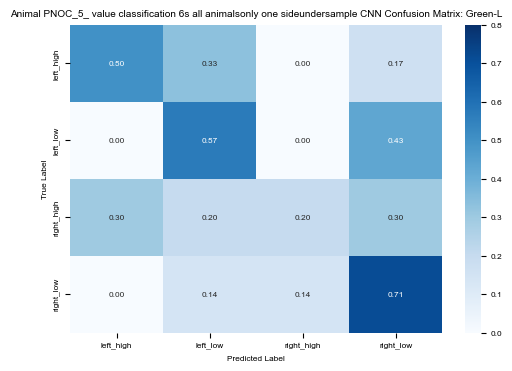

<function accuracy_score at 0x7d6aab314ca0>


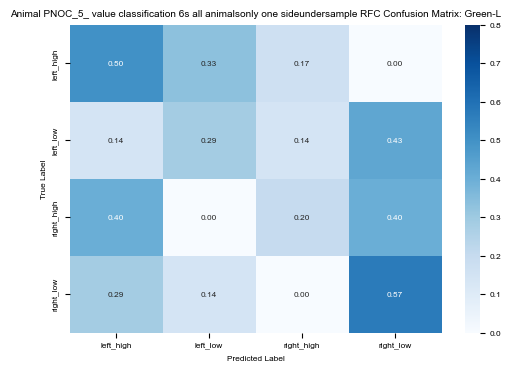

1/1 [==============================] - 1s 606ms/step
<function accuracy_score at 0x7d6aab314ca0>


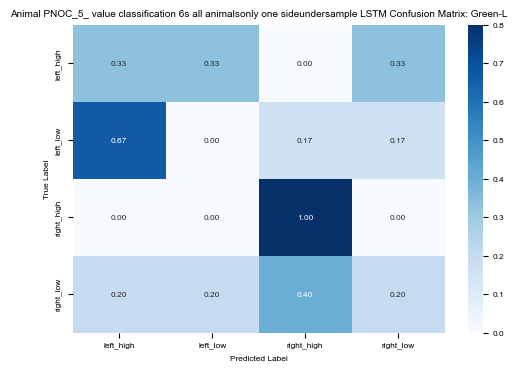


 25%|██▌       | 1/4 [00:30<01:30, 30.10s/it]

X shape: (100, 60)
y shape: (100,)
1
1/1 [==============================] - 0s 69ms/step
<function accuracy_score at 0x7d6aab314ca0>


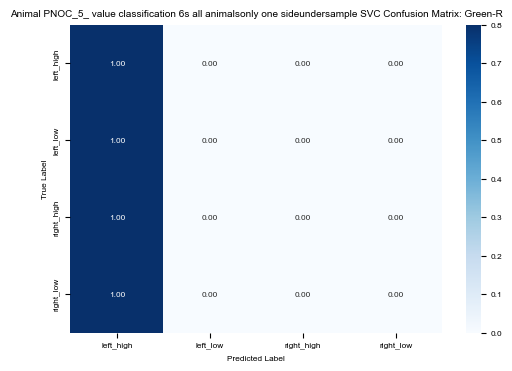

<function accuracy_score at 0x7d6aab314ca0>


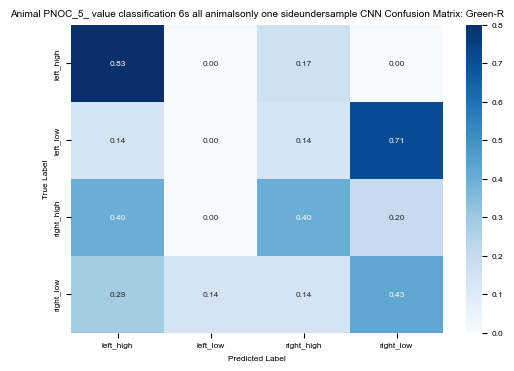

<function accuracy_score at 0x7d6aab314ca0>


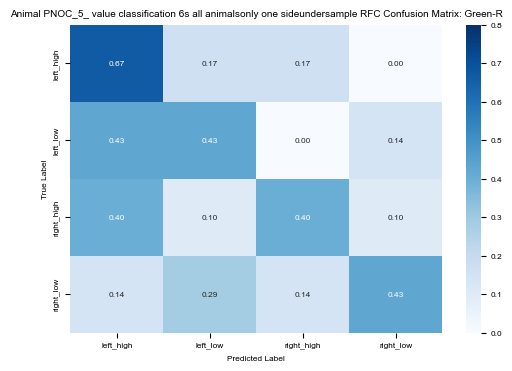

1/1 [==============================] - 1s 612ms/step
<function accuracy_score at 0x7d6aab314ca0>


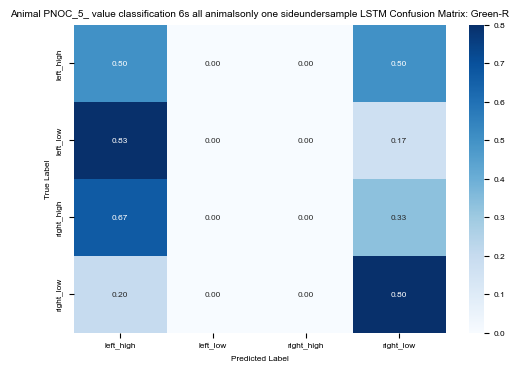


 50%|█████     | 2/4 [01:03<01:03, 31.82s/it]

X shape: (100, 60)
y shape: (100,)
2
1/1 [==============================] - 0s 65ms/step
<function accuracy_score at 0x7d6aab314ca0>


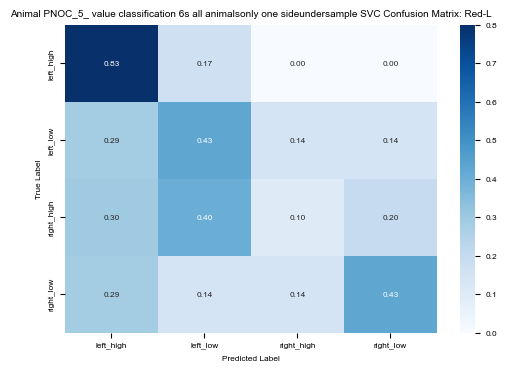

<function accuracy_score at 0x7d6aab314ca0>


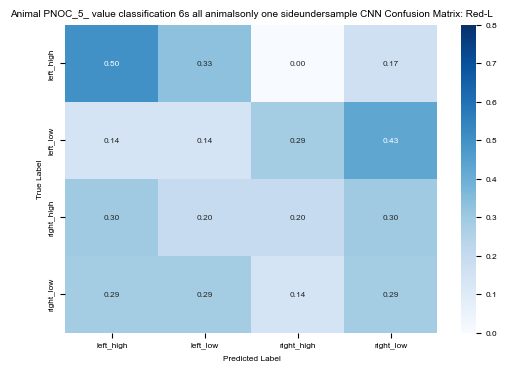

<function accuracy_score at 0x7d6aab314ca0>


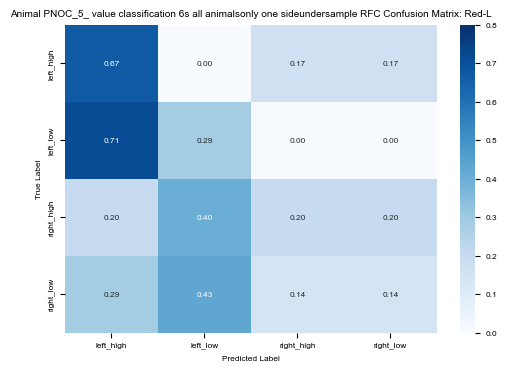

1/1 [==============================] - 1s 617ms/step
<function accuracy_score at 0x7d6aab314ca0>


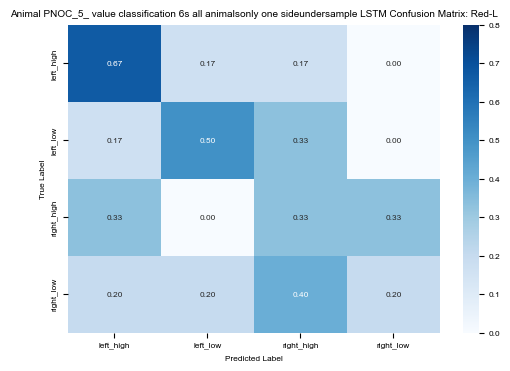


 75%|███████▌  | 3/4 [01:33<00:31, 31.39s/it]

X shape: (100, 60)
y shape: (100,)
3
1/1 [==============================] - 0s 66ms/step
<function accuracy_score at 0x7d6aab314ca0>


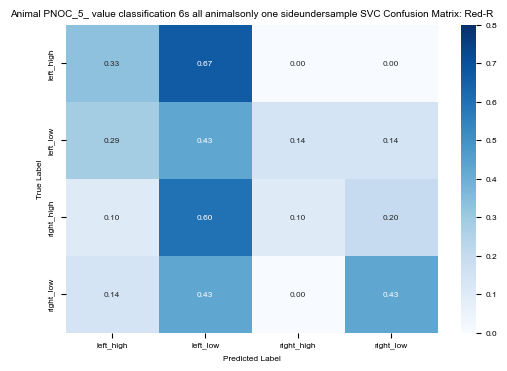

<function accuracy_score at 0x7d6aab314ca0>


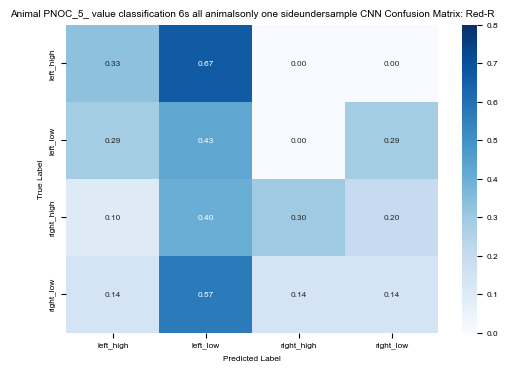

<function accuracy_score at 0x7d6aab314ca0>


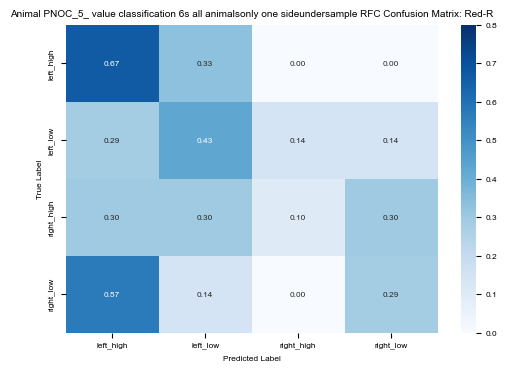

1/1 [==============================] - 1s 624ms/step
<function accuracy_score at 0x7d6aab314ca0>


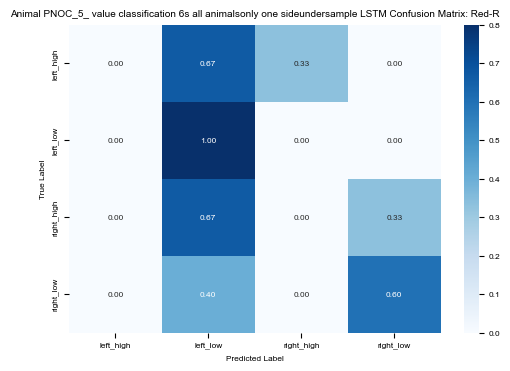


  0%|          | 0/4 [00:00<?, ?it/s]

NTS_2_



100%|██████████| 112/112 [00:03<00:00, 30.35it/s]

100%|██████████| 112/112 [00:00<00:00, 2612.31it/s]

100%|██████████| 112/112 [00:00<00:00, 2491.42it/s]

100%|██████████| 112/112 [00:00<00:00, 2350.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (468, 60)
y shape: (468,)
0
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


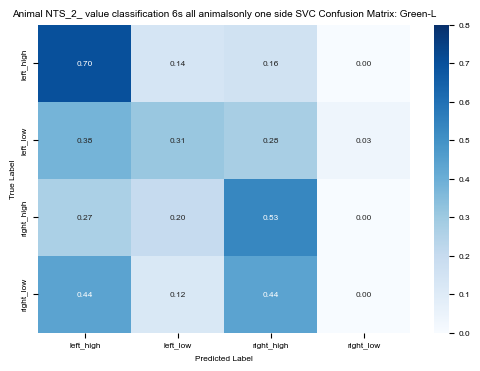

<function accuracy_score at 0x7d6aab314ca0>


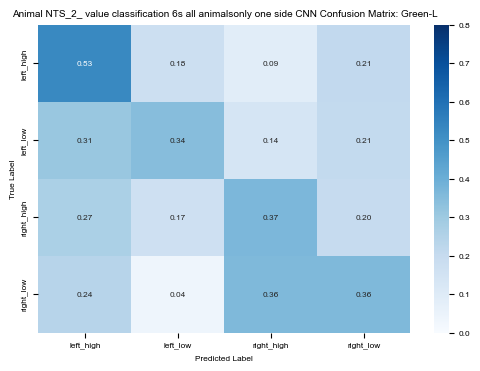

<function accuracy_score at 0x7d6aab314ca0>


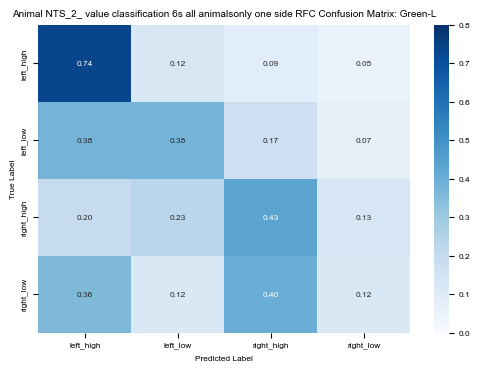

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


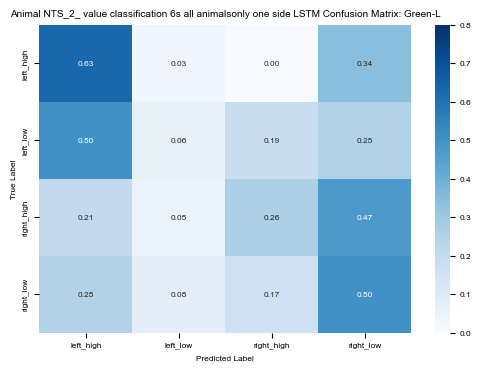


 25%|██▌       | 1/4 [00:59<02:57, 59.33s/it]

X shape: (468, 60)
y shape: (468,)
1
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


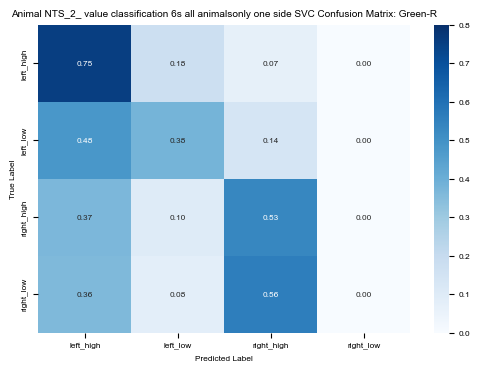

<function accuracy_score at 0x7d6aab314ca0>


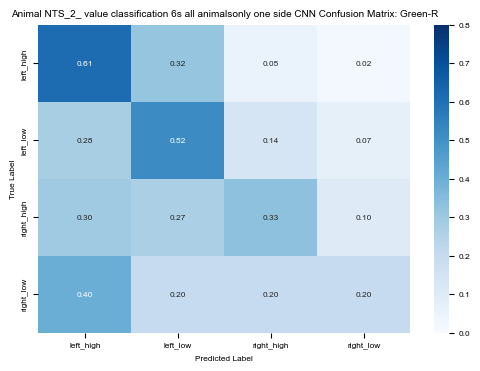

<function accuracy_score at 0x7d6aab314ca0>


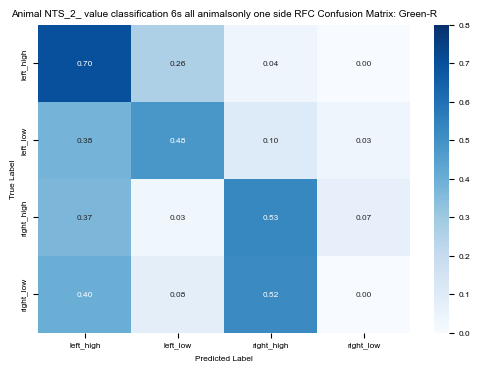

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


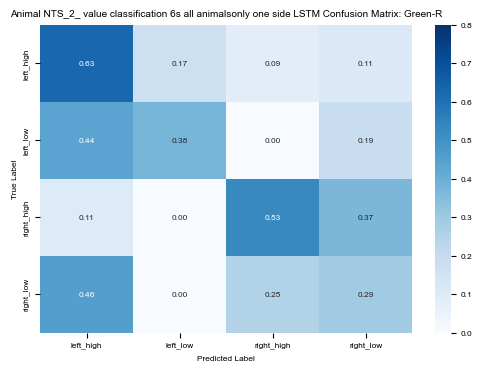


 50%|█████     | 2/4 [01:57<01:57, 58.50s/it]

X shape: (468, 60)
y shape: (468,)
2
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


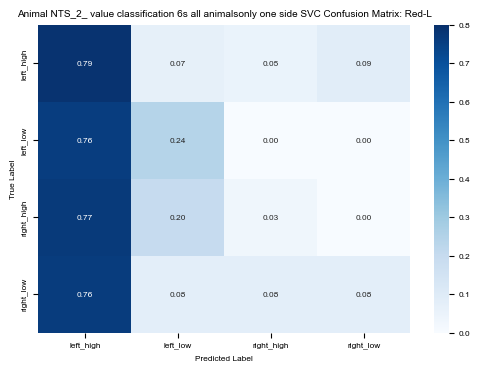

<function accuracy_score at 0x7d6aab314ca0>


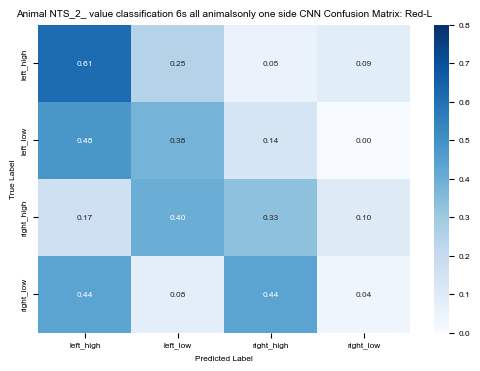

<function accuracy_score at 0x7d6aab314ca0>


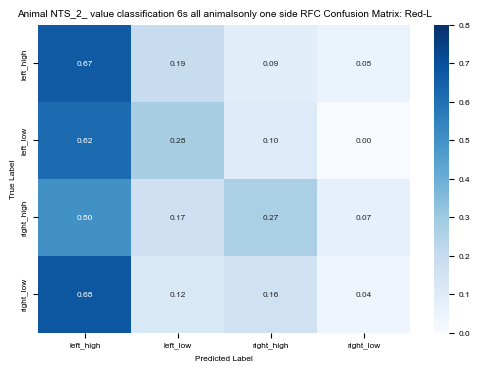

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


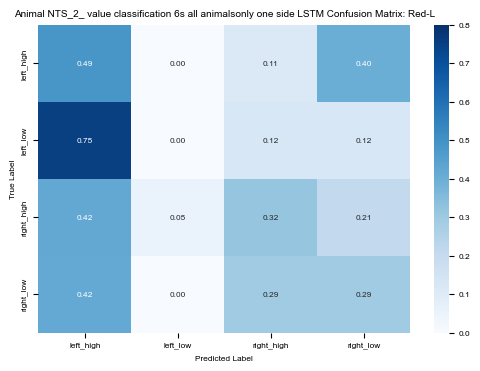


 75%|███████▌  | 3/4 [03:00<01:00, 60.74s/it]

X shape: (468, 60)
y shape: (468,)
3
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


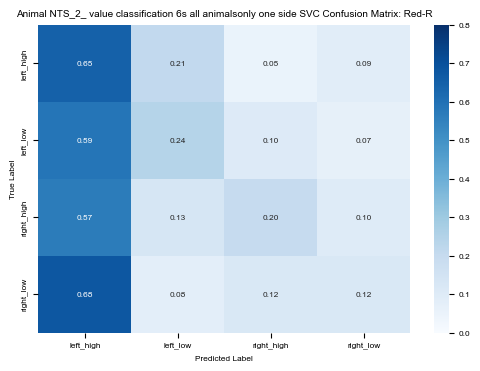

<function accuracy_score at 0x7d6aab314ca0>


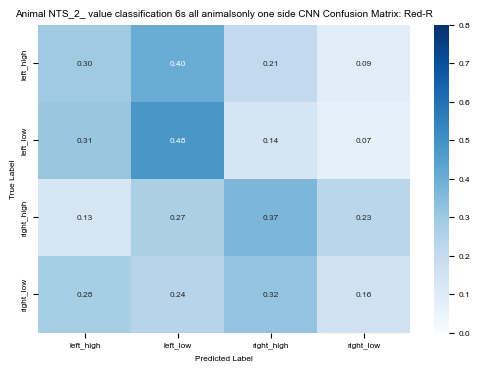

<function accuracy_score at 0x7d6aab314ca0>


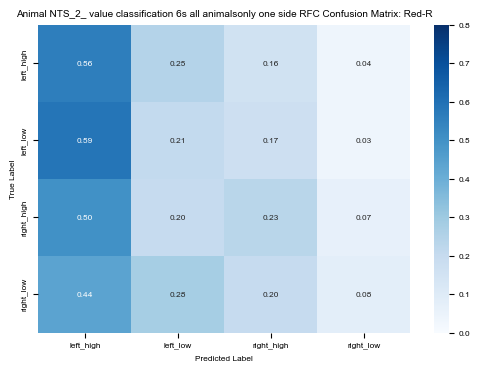

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


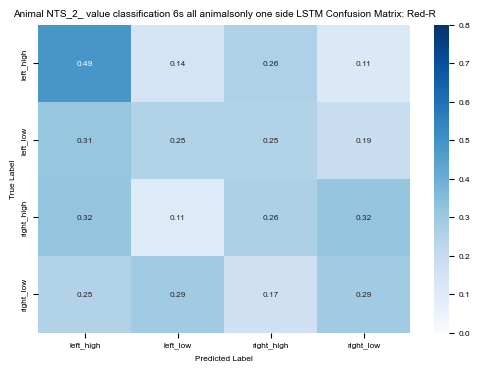


100%|██████████| 4/4 [04:07<00:00, 61.99s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (324, 60)
y shape: (324,)
0
4/4 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


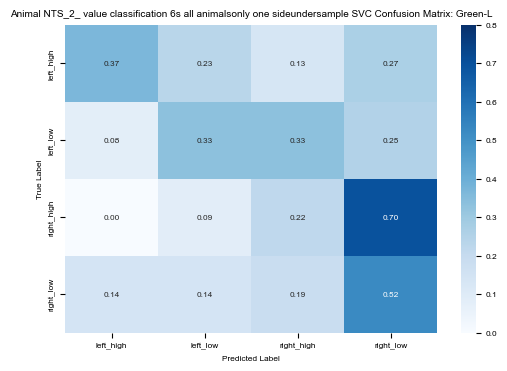

<function accuracy_score at 0x7d6aab314ca0>


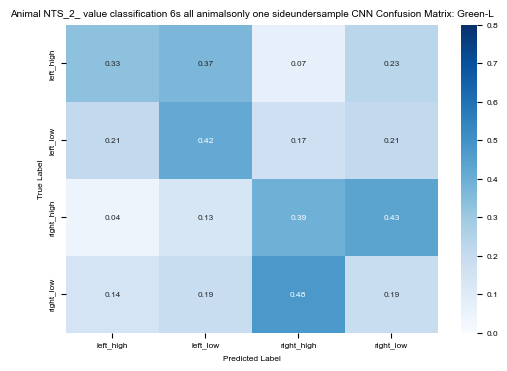

<function accuracy_score at 0x7d6aab314ca0>


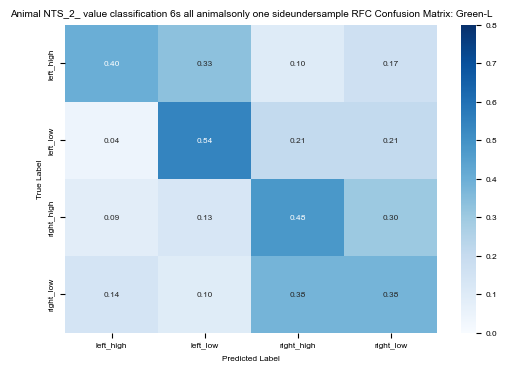

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


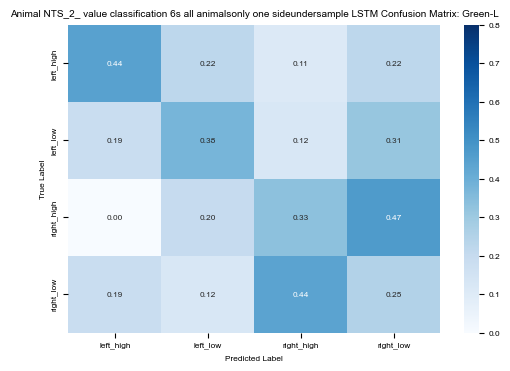


 25%|██▌       | 1/4 [00:51<02:34, 51.49s/it]

X shape: (324, 60)
y shape: (324,)
1
4/4 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


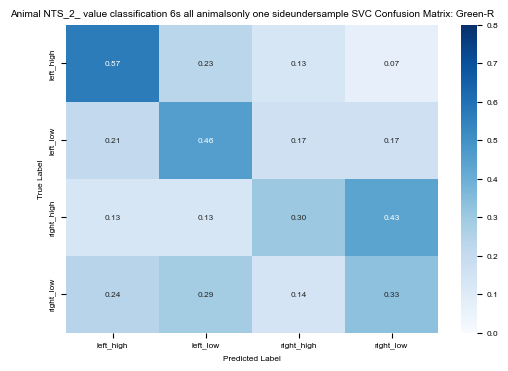

<function accuracy_score at 0x7d6aab314ca0>


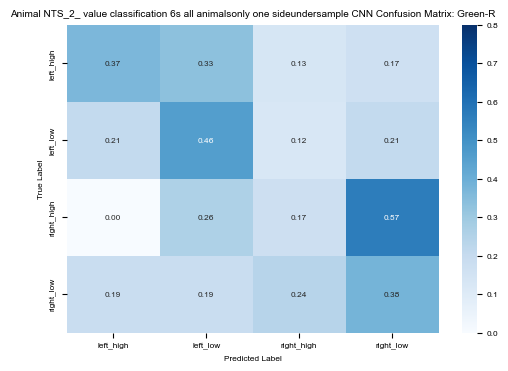

<function accuracy_score at 0x7d6aab314ca0>


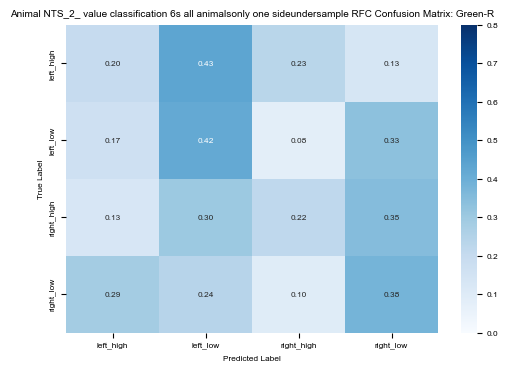

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


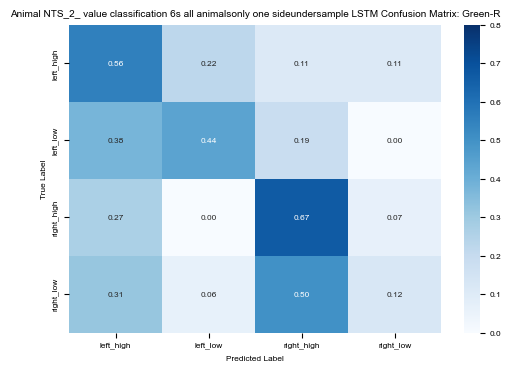


 50%|█████     | 2/4 [01:40<01:39, 49.81s/it]

X shape: (324, 60)
y shape: (324,)
2
4/4 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


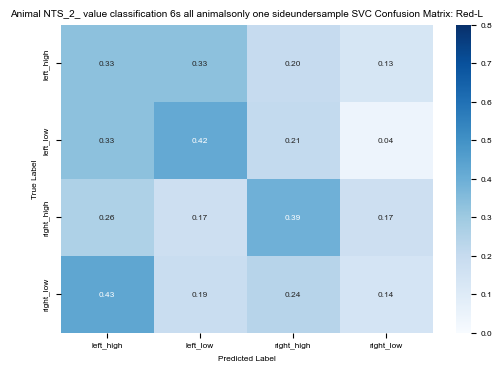

<function accuracy_score at 0x7d6aab314ca0>


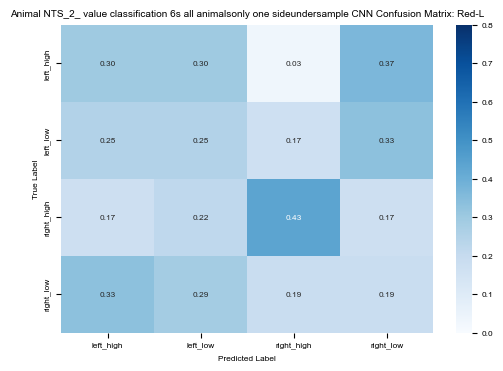

<function accuracy_score at 0x7d6aab314ca0>


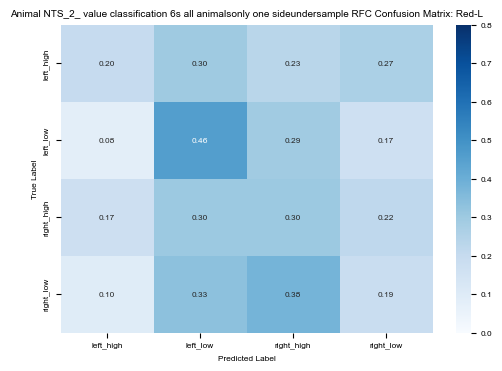

3/3 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


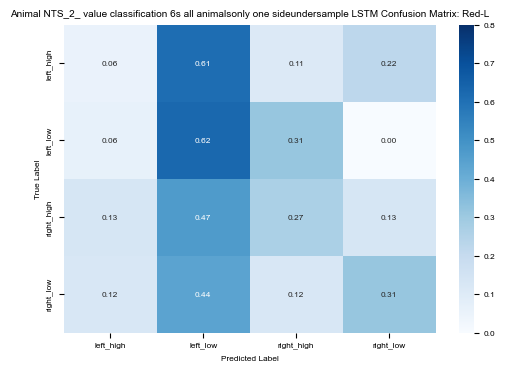


 75%|███████▌  | 3/4 [02:27<00:48, 48.81s/it]

X shape: (324, 60)
y shape: (324,)
3
4/4 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


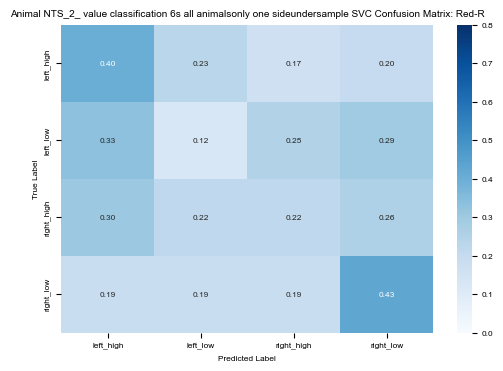

<function accuracy_score at 0x7d6aab314ca0>


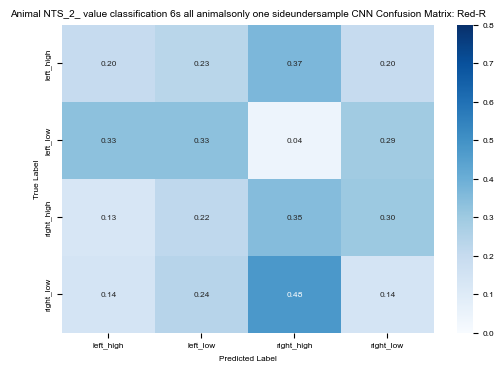

<function accuracy_score at 0x7d6aab314ca0>


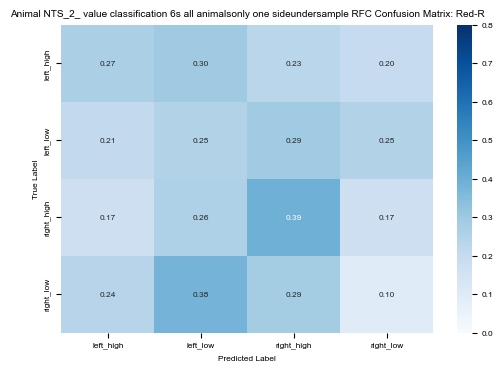

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


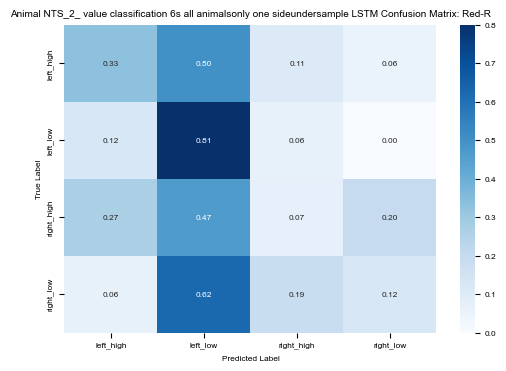


 25%|██▌       | 1/4 [07:33<22:39, 453.18s/it]

NTS_3_



100%|██████████| 112/112 [00:03<00:00, 31.76it/s]

100%|██████████| 112/112 [00:00<00:00, 2316.68it/s]

100%|██████████| 112/112 [00:00<00:00, 2665.14it/s]

100%|██████████| 112/112 [00:00<00:00, 2401.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (451, 60)
y shape: (451,)
0
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


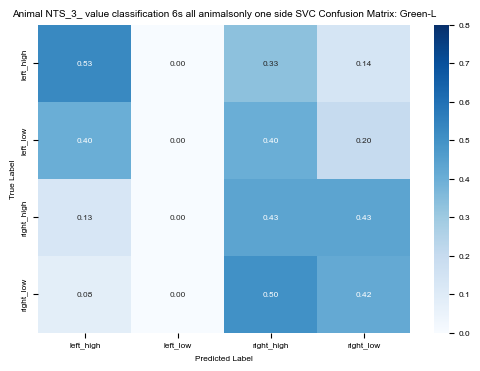

<function accuracy_score at 0x7d6aab314ca0>


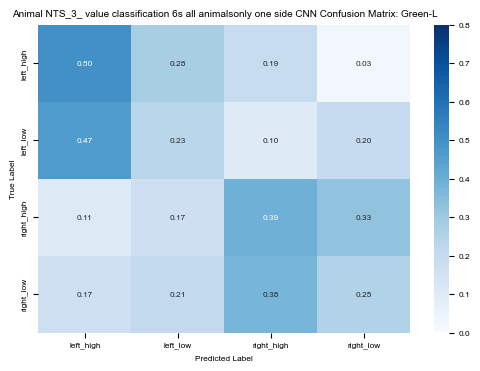

<function accuracy_score at 0x7d6aab314ca0>


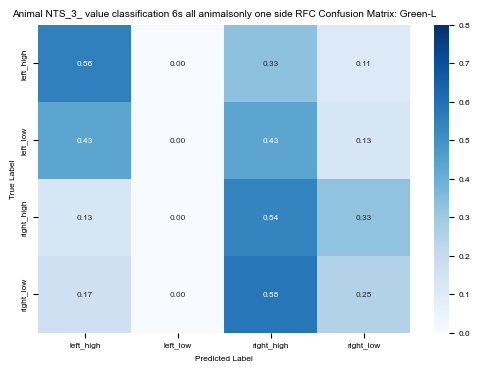

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


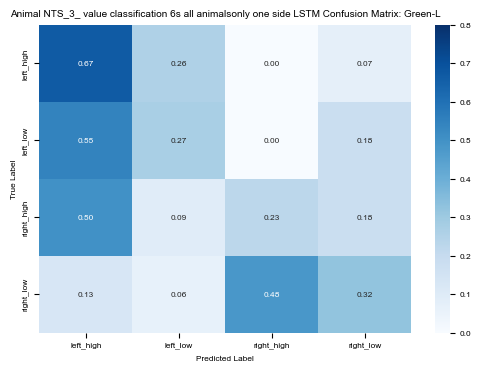


 25%|██▌       | 1/4 [00:57<02:52, 57.36s/it]

X shape: (451, 60)
y shape: (451,)
1
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


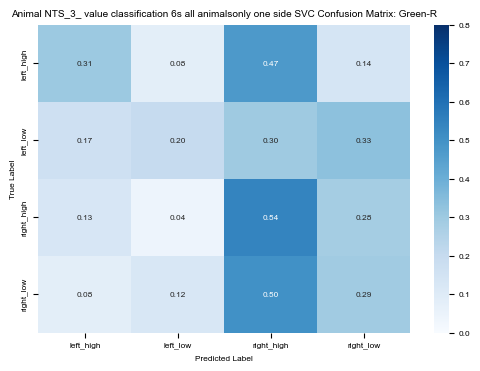

<function accuracy_score at 0x7d6aab314ca0>


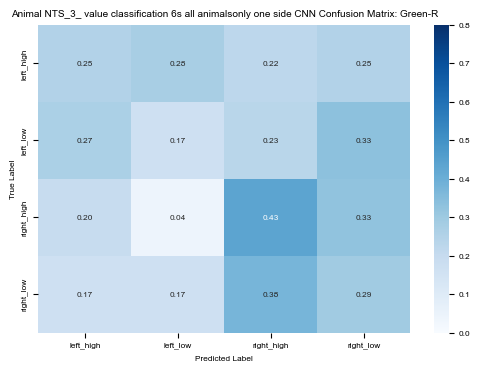

<function accuracy_score at 0x7d6aab314ca0>


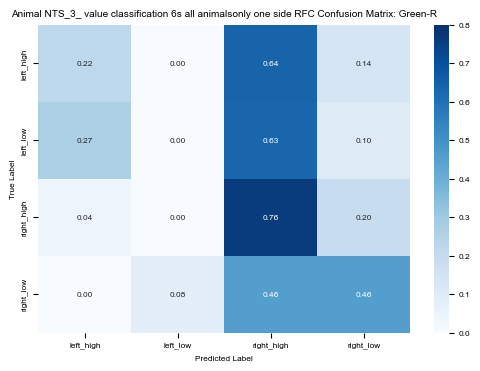

3/3 [==============================] - 6s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


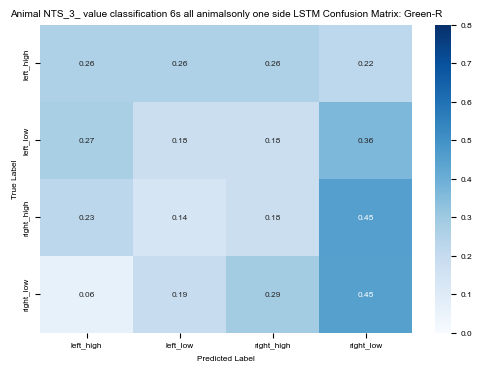


 50%|█████     | 2/4 [02:01<02:02, 61.49s/it]

X shape: (451, 60)
y shape: (451,)
2
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


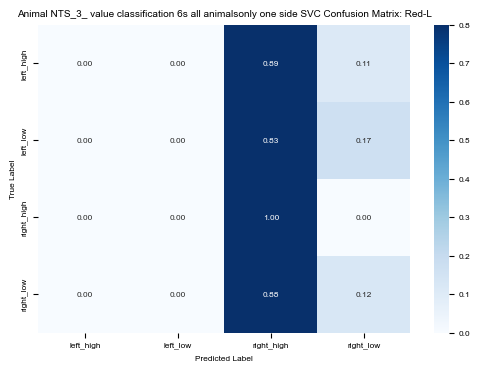

<function accuracy_score at 0x7d6aab314ca0>


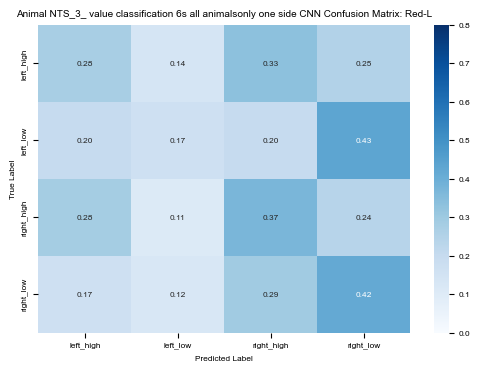

<function accuracy_score at 0x7d6aab314ca0>


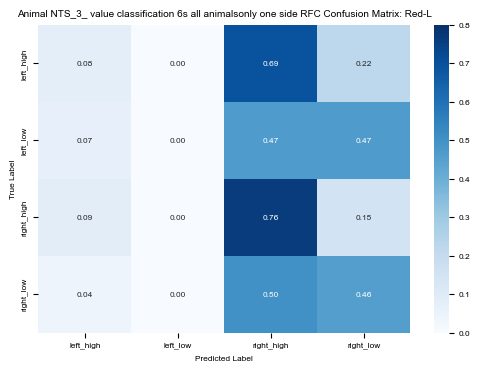

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


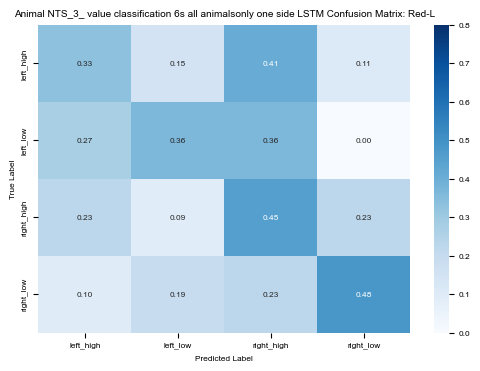


 75%|███████▌  | 3/4 [03:08<01:03, 63.90s/it]

X shape: (451, 60)
y shape: (451,)
3
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


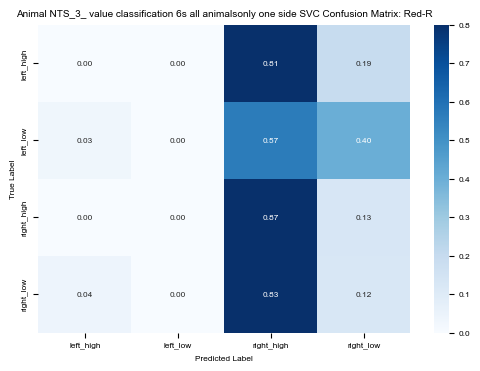

<function accuracy_score at 0x7d6aab314ca0>


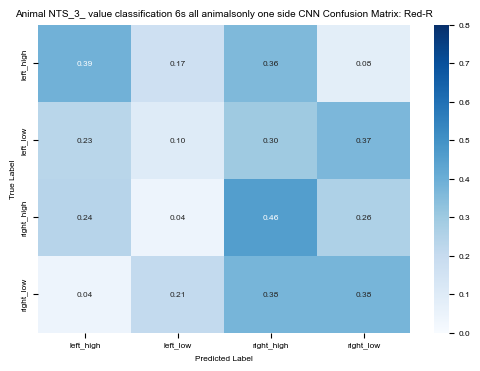

<function accuracy_score at 0x7d6aab314ca0>


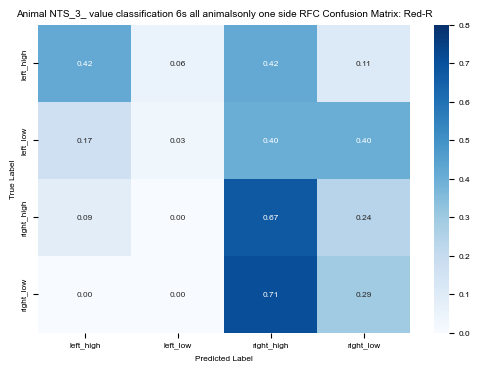

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


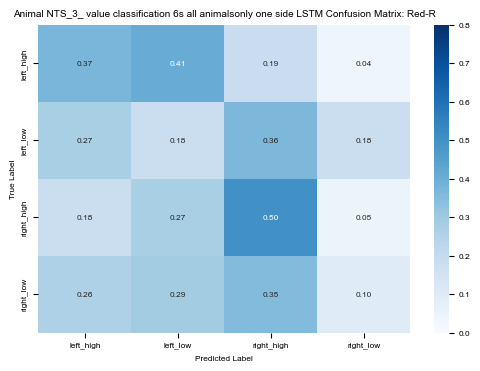


100%|██████████| 4/4 [04:08<00:00, 62.11s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (296, 60)
y shape: (296,)
0
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


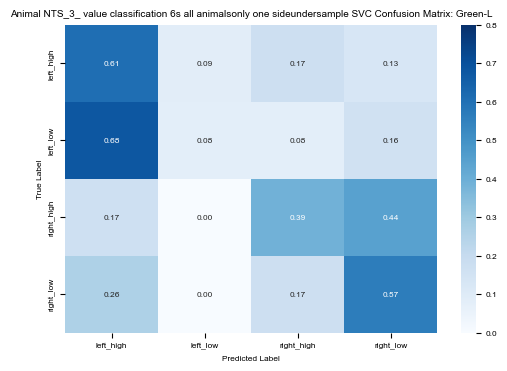

<function accuracy_score at 0x7d6aab314ca0>


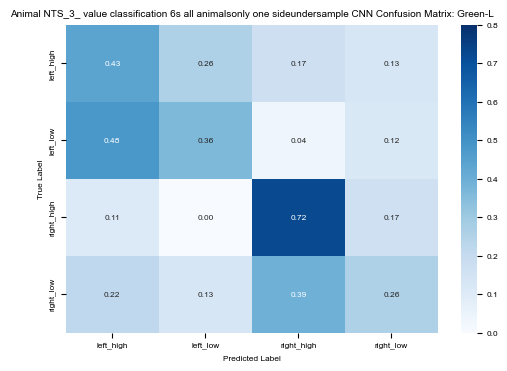

<function accuracy_score at 0x7d6aab314ca0>


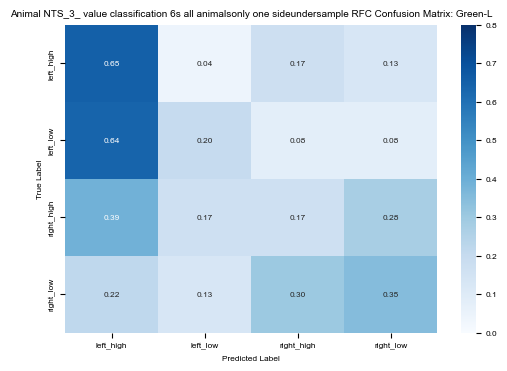

2/2 [==============================] - 1s 7ms/step
<function accuracy_score at 0x7d6aab314ca0>


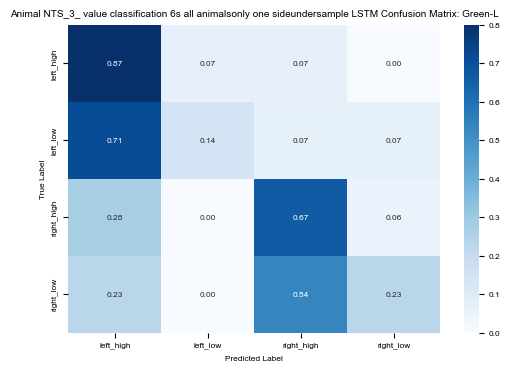


 25%|██▌       | 1/4 [00:43<02:10, 43.46s/it]

X shape: (296, 60)
y shape: (296,)
1
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


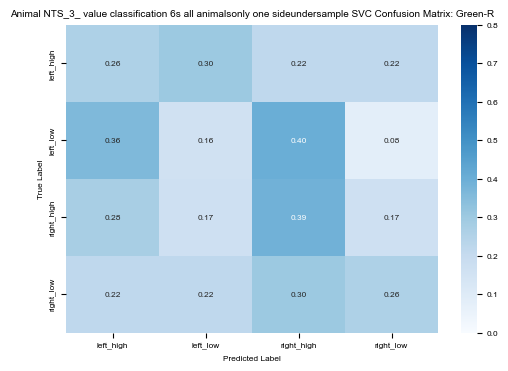

<function accuracy_score at 0x7d6aab314ca0>


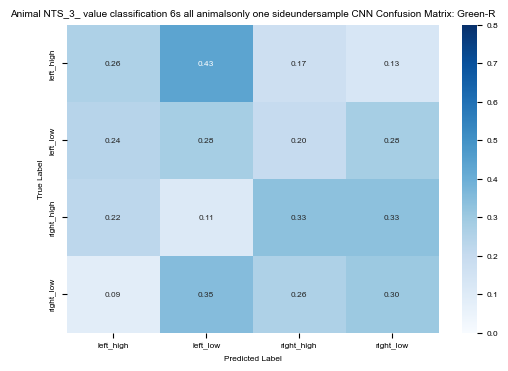

<function accuracy_score at 0x7d6aab314ca0>


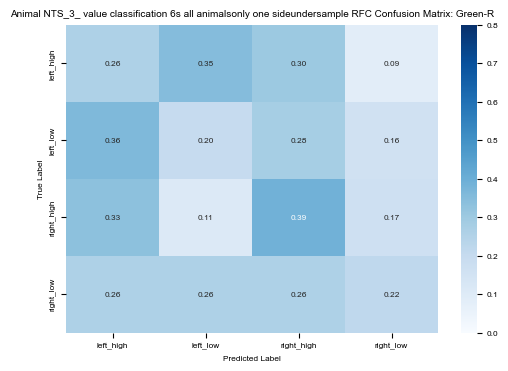

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


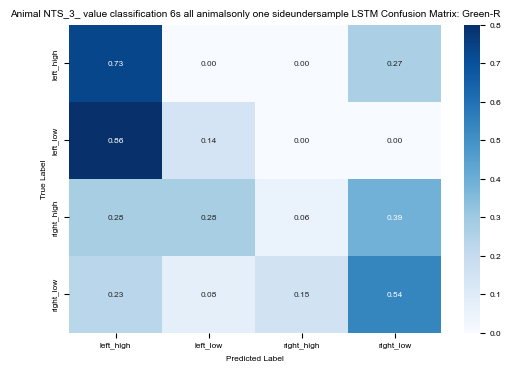


 50%|█████     | 2/4 [01:26<01:26, 43.30s/it]

X shape: (296, 60)
y shape: (296,)
2
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


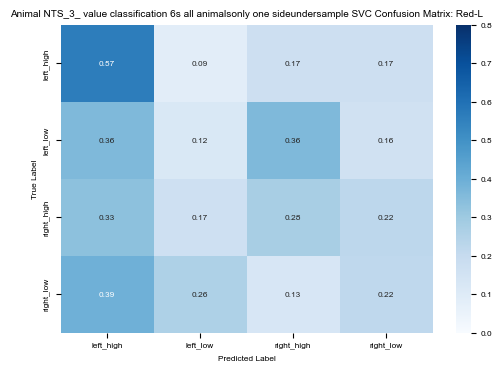

<function accuracy_score at 0x7d6aab314ca0>


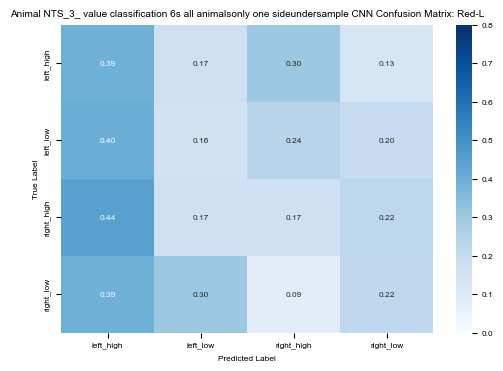

<function accuracy_score at 0x7d6aab314ca0>


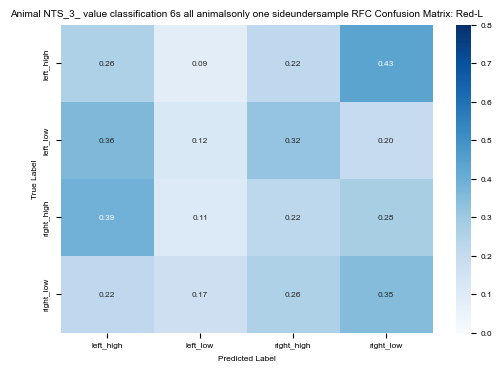

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


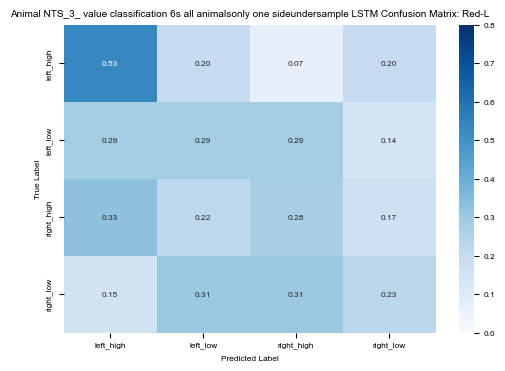


 75%|███████▌  | 3/4 [02:12<00:44, 44.60s/it]

X shape: (296, 60)
y shape: (296,)
3
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


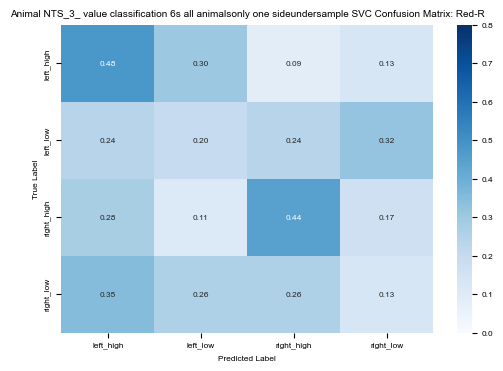

<function accuracy_score at 0x7d6aab314ca0>


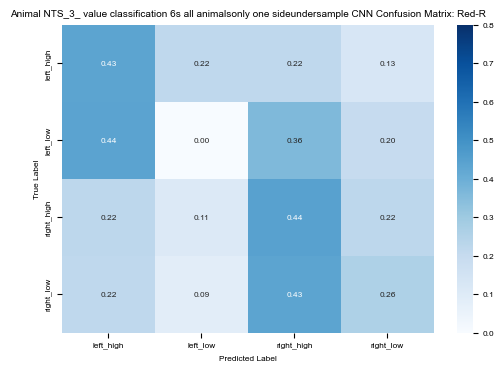

<function accuracy_score at 0x7d6aab314ca0>


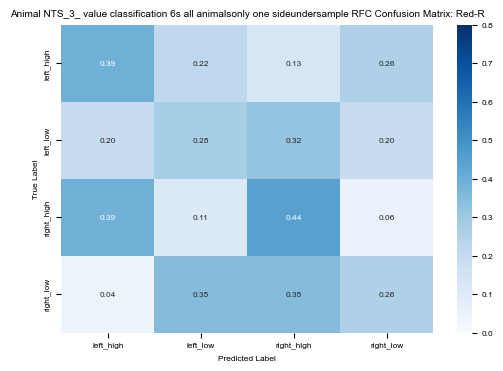

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


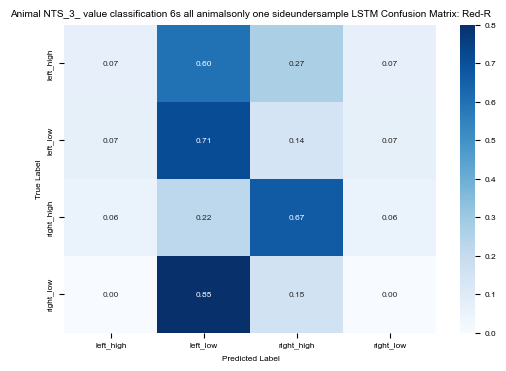


 50%|█████     | 2/4 [14:41<14:37, 438.73s/it]

NTS_5_



100%|██████████| 96/96 [00:03<00:00, 26.08it/s]

100%|██████████| 96/96 [00:00<00:00, 2548.87it/s]

100%|██████████| 96/96 [00:00<00:00, 2356.79it/s]

100%|██████████| 96/96 [00:00<00:00, 2253.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (151, 60)
y shape: (151,)
0
2/2 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


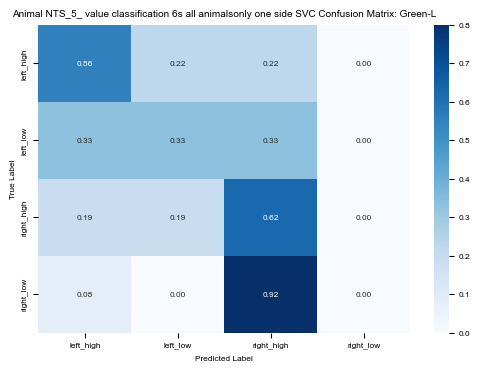

<function accuracy_score at 0x7d6aab314ca0>


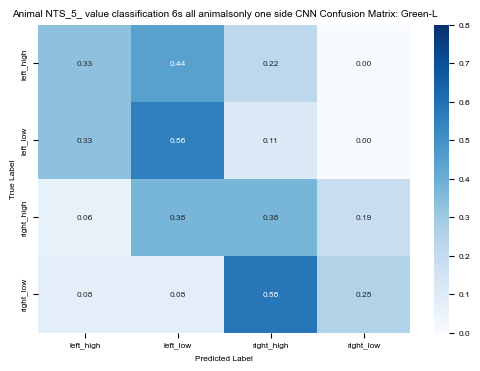

<function accuracy_score at 0x7d6aab314ca0>


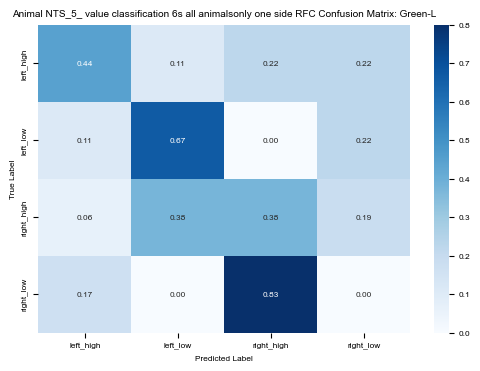

1/1 [==============================] - 1s 621ms/step
<function accuracy_score at 0x7d6aab314ca0>


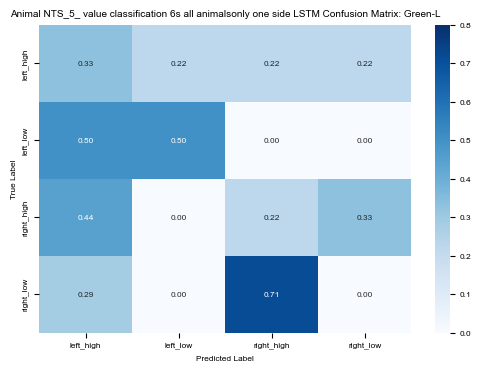


 25%|██▌       | 1/4 [00:33<01:41, 33.80s/it]

X shape: (151, 60)
y shape: (151,)
1
2/2 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


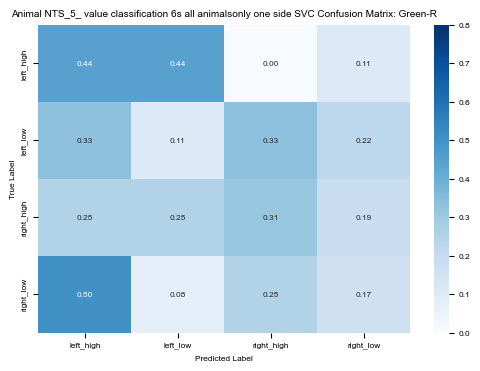

<function accuracy_score at 0x7d6aab314ca0>


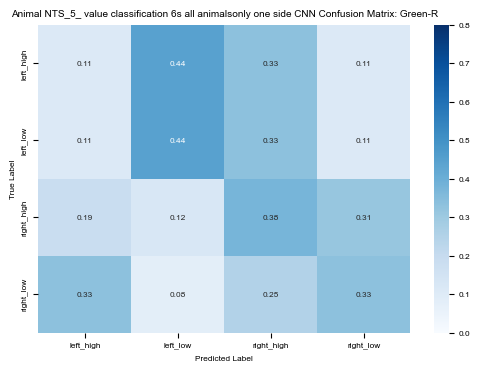

<function accuracy_score at 0x7d6aab314ca0>


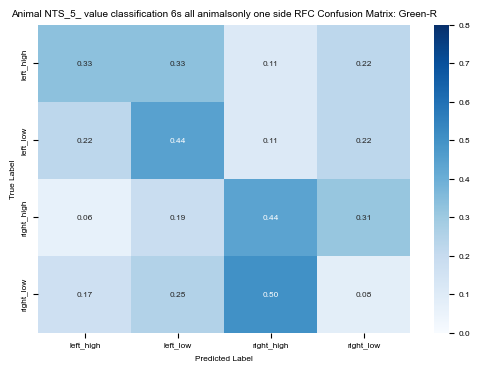

1/1 [==============================] - 1s 602ms/step
<function accuracy_score at 0x7d6aab314ca0>


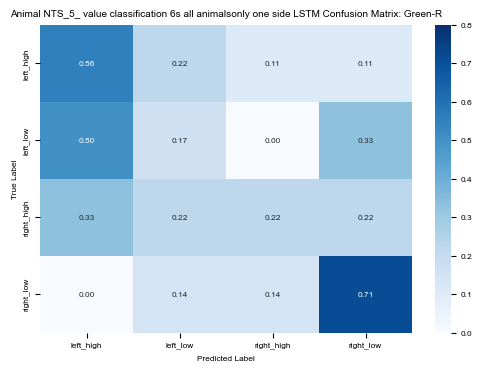


 50%|█████     | 2/4 [01:07<01:07, 33.50s/it]

X shape: (151, 60)
y shape: (151,)
2
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


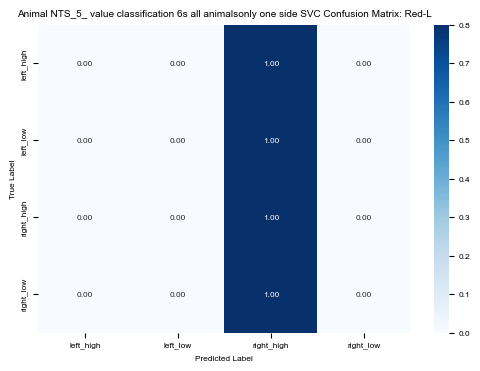

<function accuracy_score at 0x7d6aab314ca0>


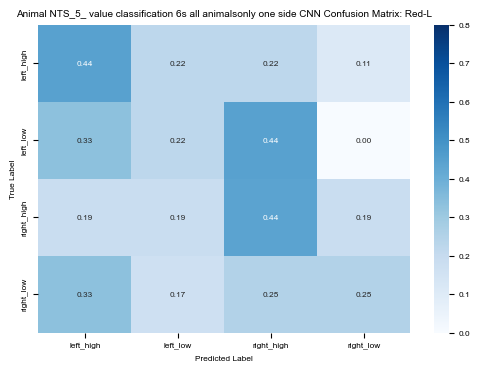

<function accuracy_score at 0x7d6aab314ca0>


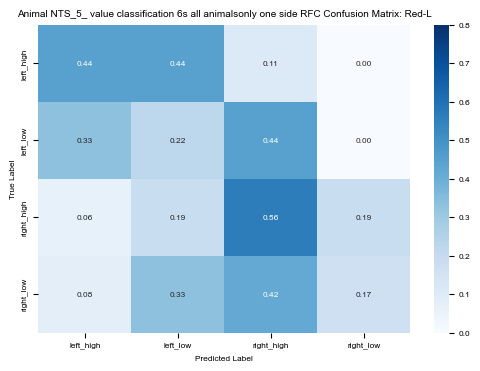

1/1 [==============================] - 1s 696ms/step
<function accuracy_score at 0x7d6aab314ca0>


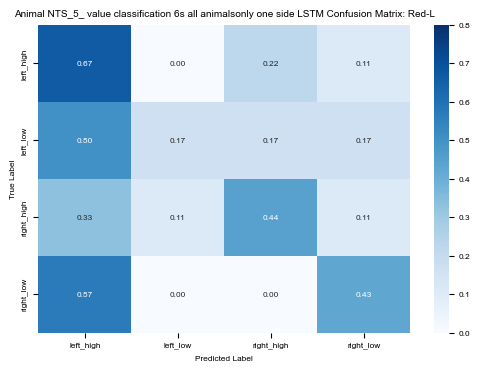


 75%|███████▌  | 3/4 [01:40<00:33, 33.30s/it]

X shape: (151, 60)
y shape: (151,)
3
2/2 [==============================] - 0s 4ms/step
<function accuracy_score at 0x7d6aab314ca0>


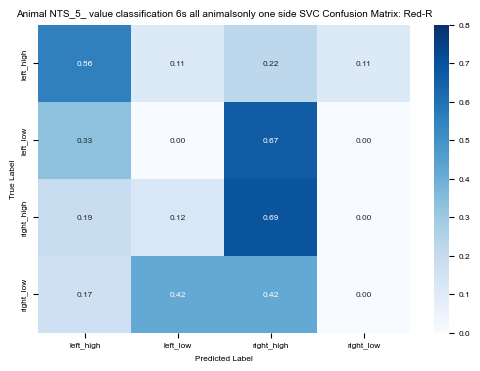

<function accuracy_score at 0x7d6aab314ca0>


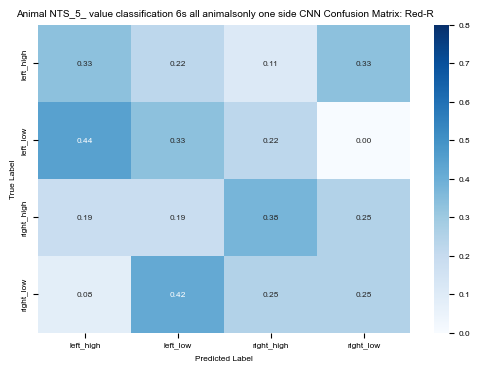

<function accuracy_score at 0x7d6aab314ca0>


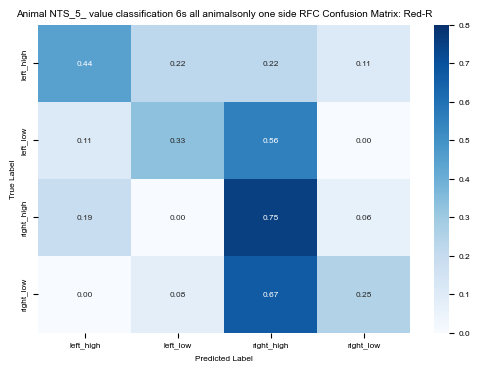

1/1 [==============================] - 1s 655ms/step
<function accuracy_score at 0x7d6aab314ca0>


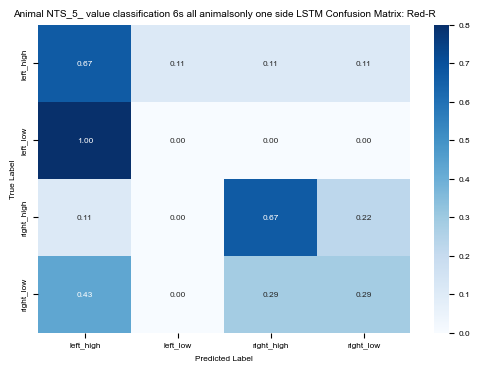


100%|██████████| 4/4 [02:13<00:00, 33.38s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (128, 60)
y shape: (128,)
0
2/2 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


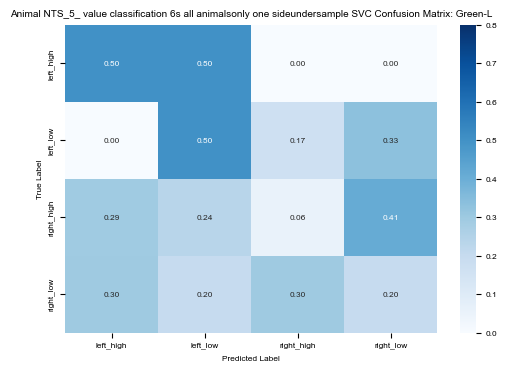

<function accuracy_score at 0x7d6aab314ca0>


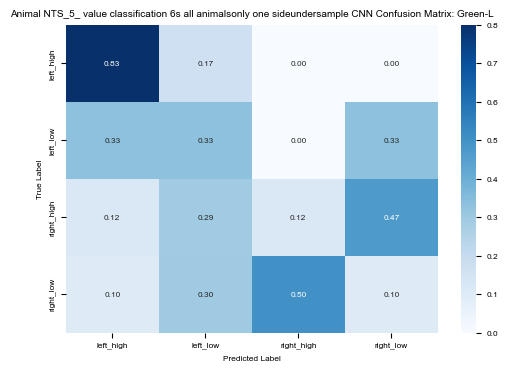

<function accuracy_score at 0x7d6aab314ca0>


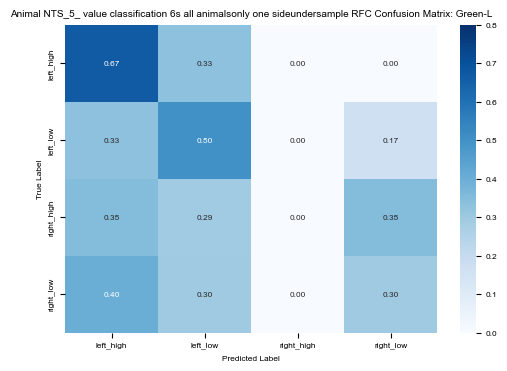

1/1 [==============================] - 1s 621ms/step
<function accuracy_score at 0x7d6aab314ca0>


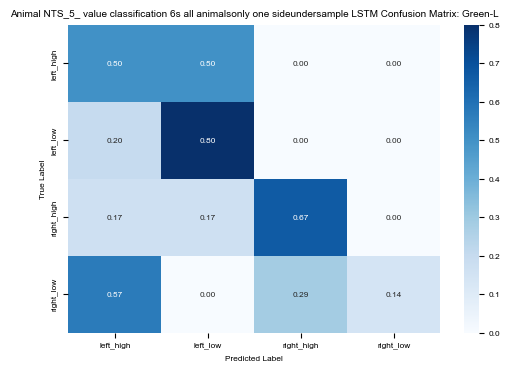


 25%|██▌       | 1/4 [00:37<01:51, 37.15s/it]

X shape: (128, 60)
y shape: (128,)
1
2/2 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


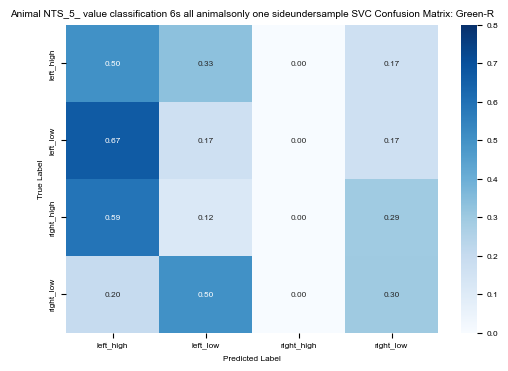

<function accuracy_score at 0x7d6aab314ca0>


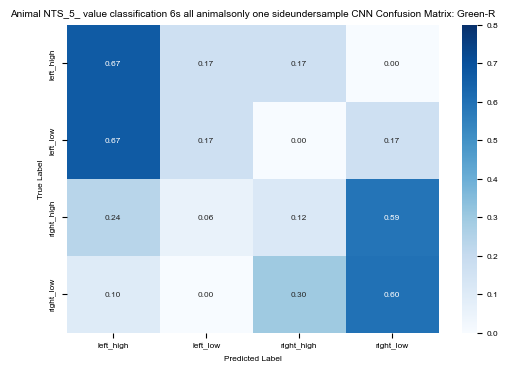

<function accuracy_score at 0x7d6aab314ca0>


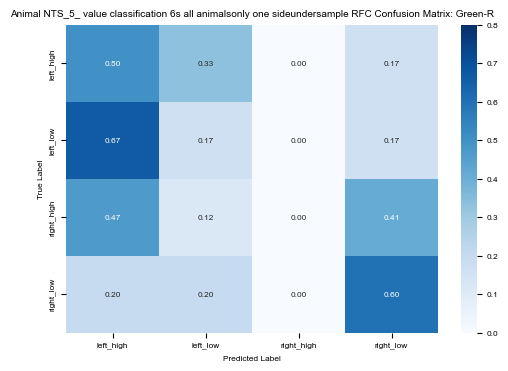

1/1 [==============================] - 1s 604ms/step
<function accuracy_score at 0x7d6aab314ca0>


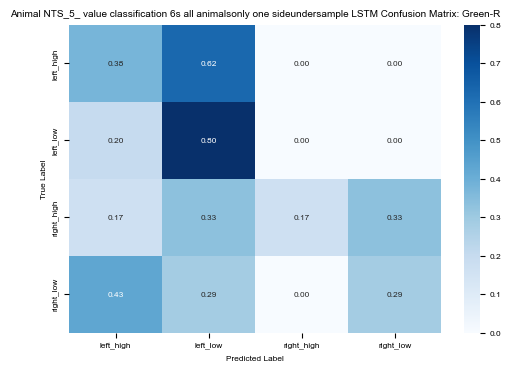


 50%|█████     | 2/4 [01:11<01:10, 35.48s/it]

X shape: (128, 60)
y shape: (128,)
2
2/2 [==============================] - 0s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


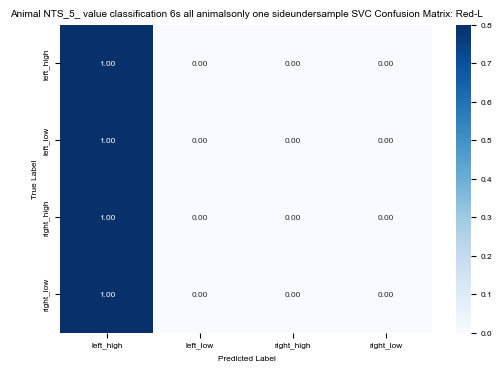

<function accuracy_score at 0x7d6aab314ca0>


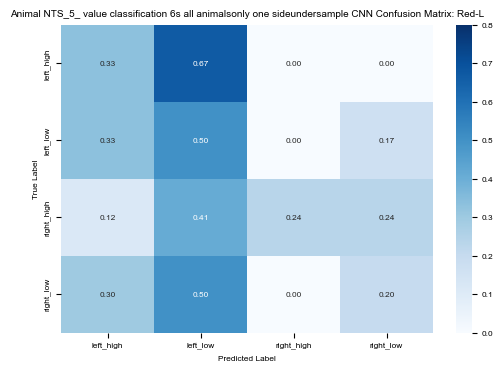

<function accuracy_score at 0x7d6aab314ca0>


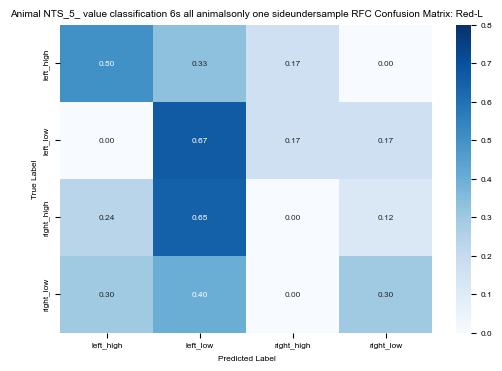

1/1 [==============================] - 1s 642ms/step
<function accuracy_score at 0x7d6aab314ca0>


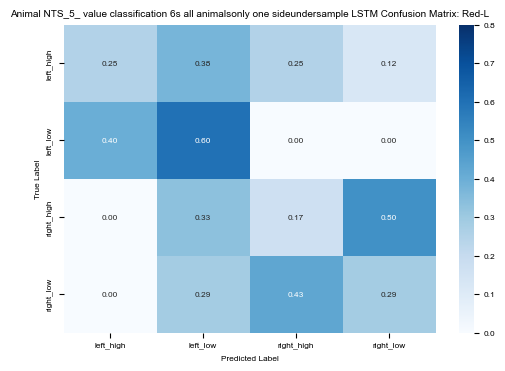


 75%|███████▌  | 3/4 [01:42<00:33, 33.62s/it]

X shape: (128, 60)
y shape: (128,)
3
2/2 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


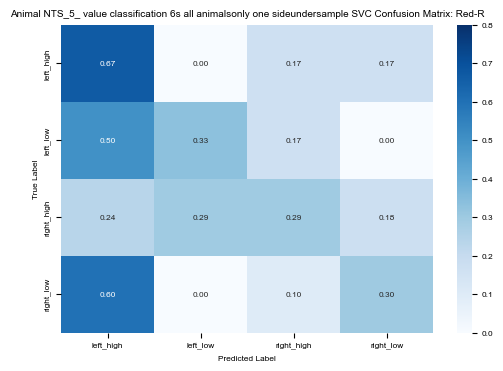

<function accuracy_score at 0x7d6aab314ca0>


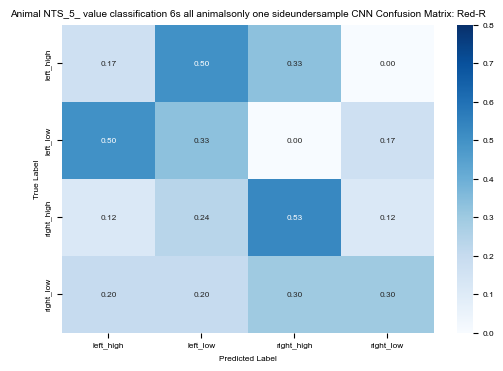

<function accuracy_score at 0x7d6aab314ca0>


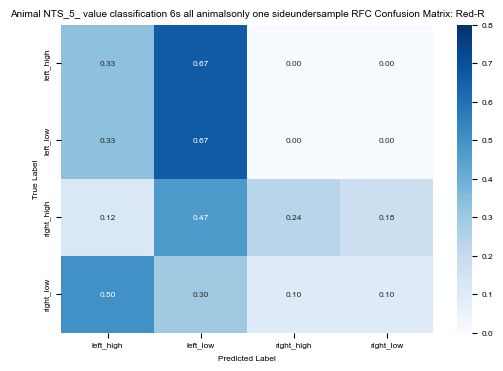

1/1 [==============================] - 1s 660ms/step
<function accuracy_score at 0x7d6aab314ca0>


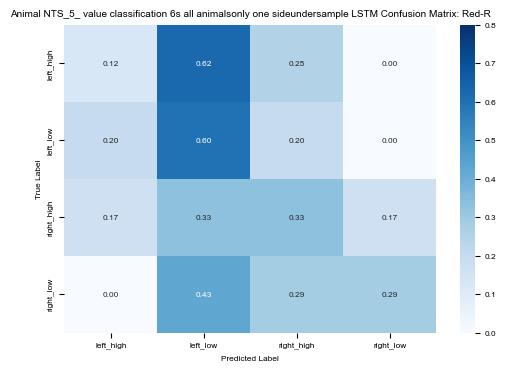


 75%|███████▌  | 3/4 [19:19<06:05, 365.20s/it]

NTS_6_



100%|██████████| 96/96 [00:00<00:00, 1059.35it/s]

100%|██████████| 96/96 [00:04<00:00, 23.52it/s]

100%|██████████| 96/96 [00:00<00:00, 2634.16it/s]

100%|██████████| 96/96 [00:00<00:00, 2454.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (477, 60)
y shape: (477,)
0
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


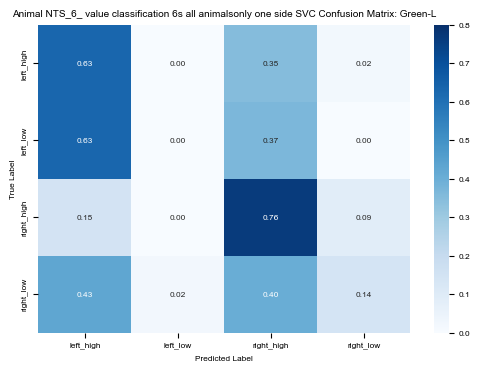

<function accuracy_score at 0x7d6aab314ca0>


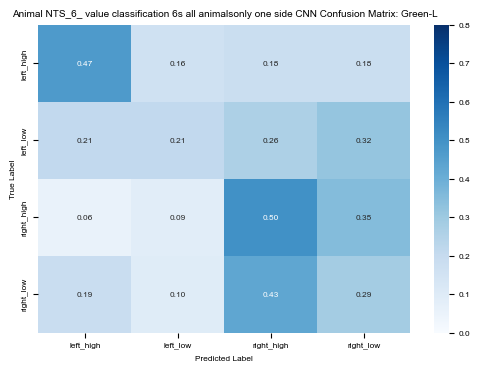

<function accuracy_score at 0x7d6aab314ca0>


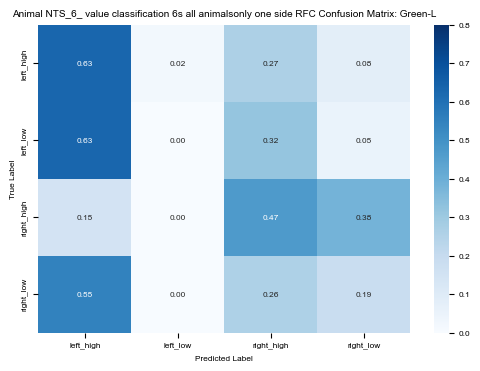

3/3 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


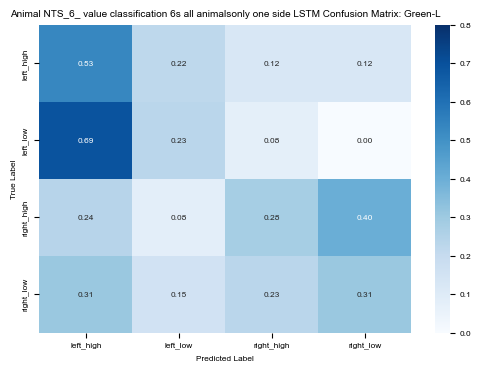


 25%|██▌       | 1/4 [01:08<03:25, 68.44s/it]

X shape: (477, 60)
y shape: (477,)
1
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


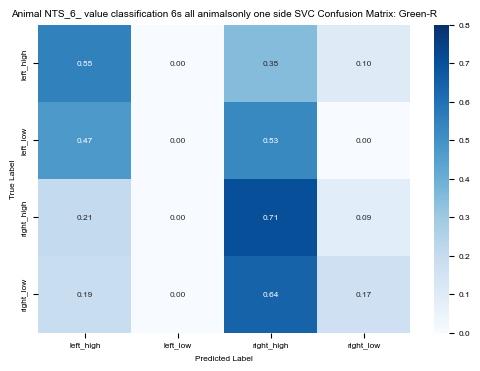

<function accuracy_score at 0x7d6aab314ca0>


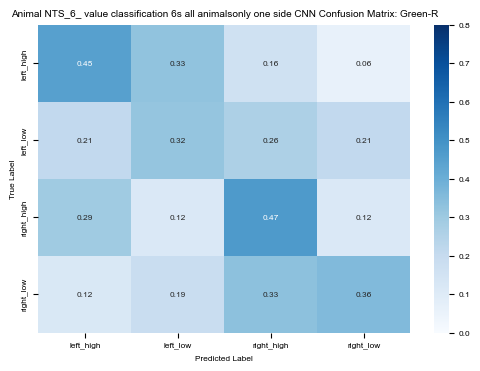

<function accuracy_score at 0x7d6aab314ca0>


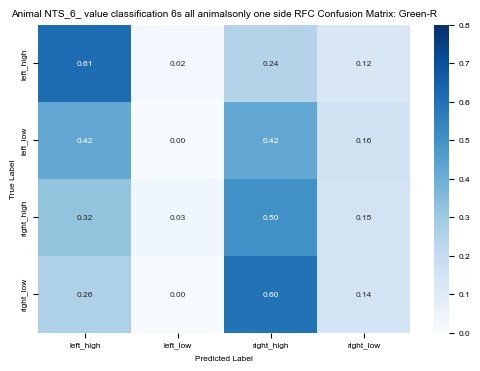

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


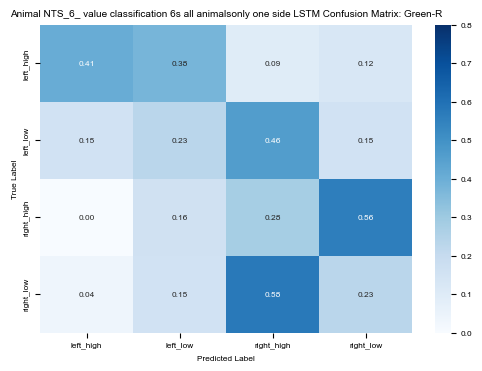


 50%|█████     | 2/4 [02:10<02:09, 64.93s/it]

X shape: (477, 60)
y shape: (477,)
2
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


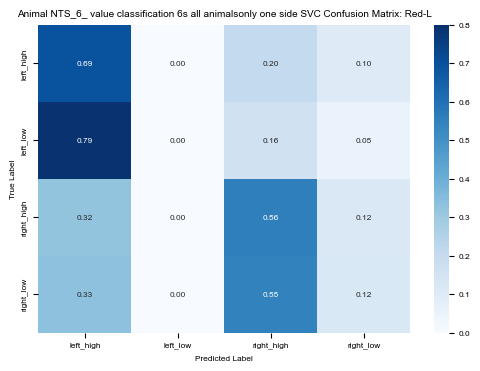

<function accuracy_score at 0x7d6aab314ca0>


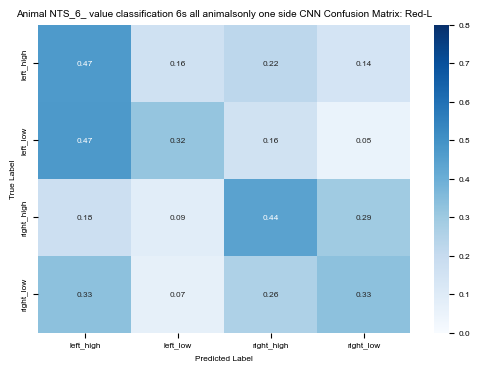

<function accuracy_score at 0x7d6aab314ca0>


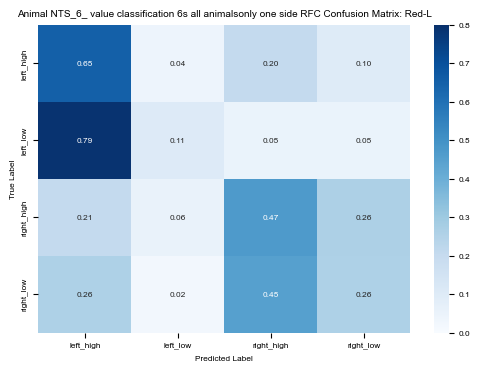

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


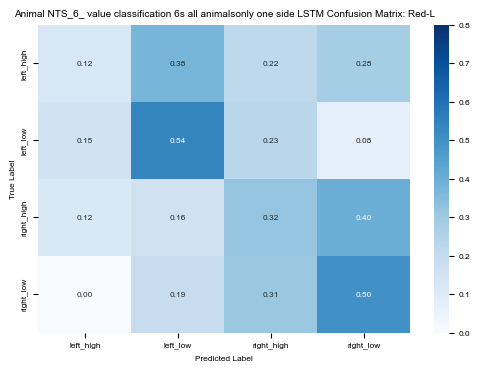


 75%|███████▌  | 3/4 [03:08<01:01, 61.66s/it]

X shape: (477, 60)
y shape: (477,)
3
5/5 [==============================] - 0s 2ms/step
<function accuracy_score at 0x7d6aab314ca0>


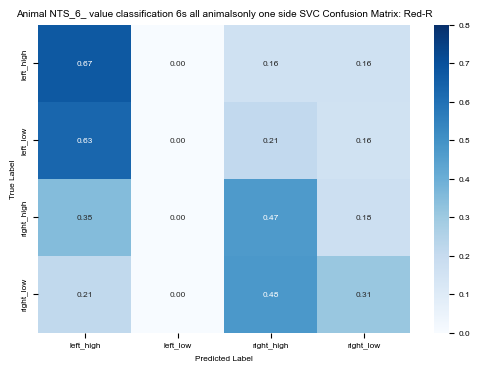

<function accuracy_score at 0x7d6aab314ca0>


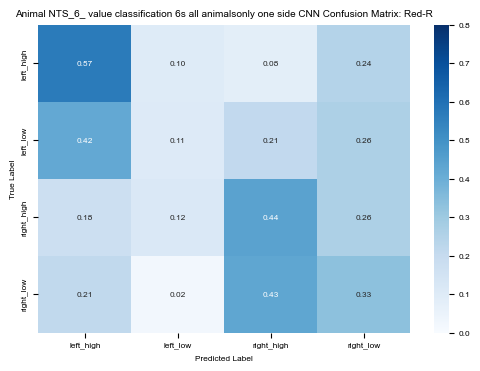

<function accuracy_score at 0x7d6aab314ca0>


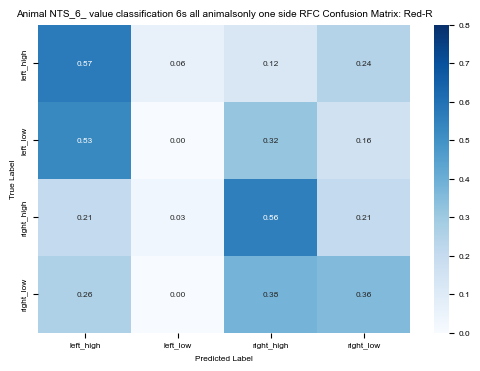

3/3 [==============================] - 1s 5ms/step
<function accuracy_score at 0x7d6aab314ca0>


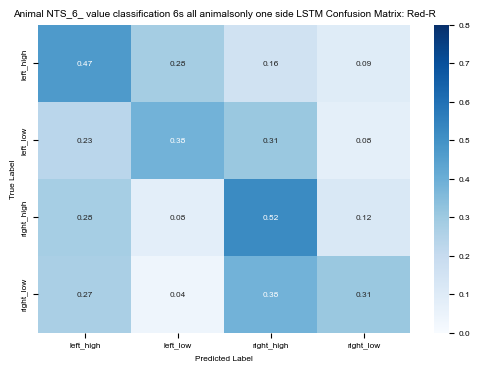


100%|██████████| 4/4 [04:10<00:00, 62.53s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

X shape: (272, 60)
y shape: (272,)
0
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


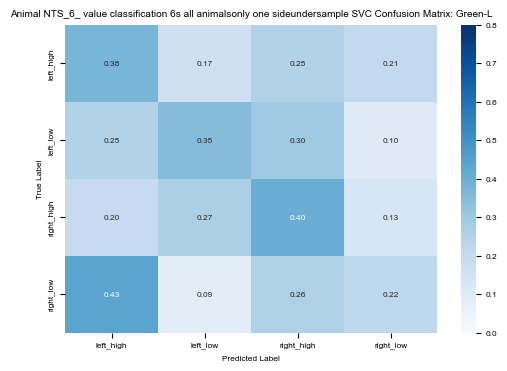

<function accuracy_score at 0x7d6aab314ca0>


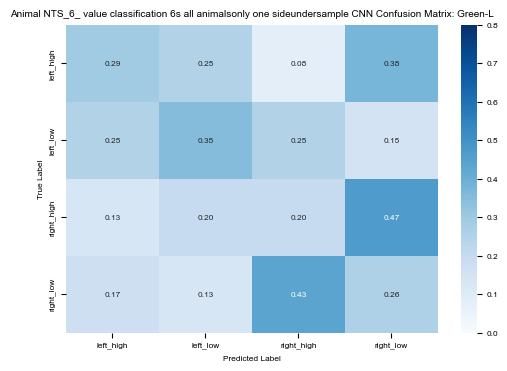

<function accuracy_score at 0x7d6aab314ca0>


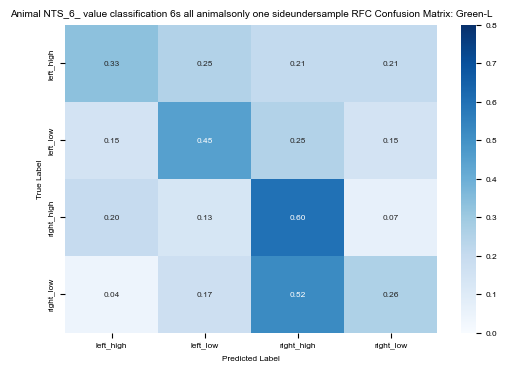

2/2 [==============================] - 1s 7ms/step
<function accuracy_score at 0x7d6aab314ca0>


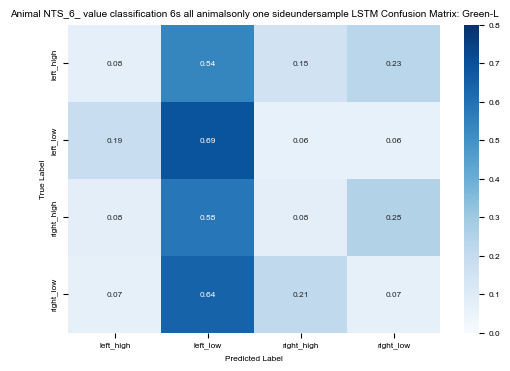


 25%|██▌       | 1/4 [00:42<02:06, 42.11s/it]

X shape: (272, 60)
y shape: (272,)
1
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


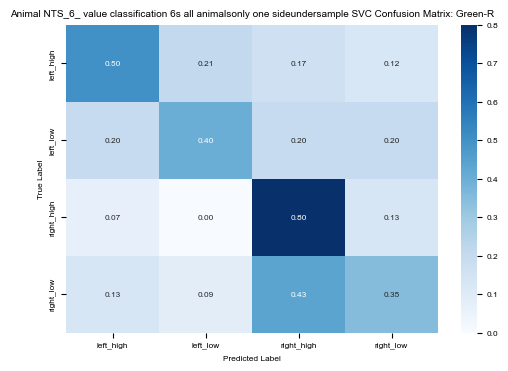

<function accuracy_score at 0x7d6aab314ca0>


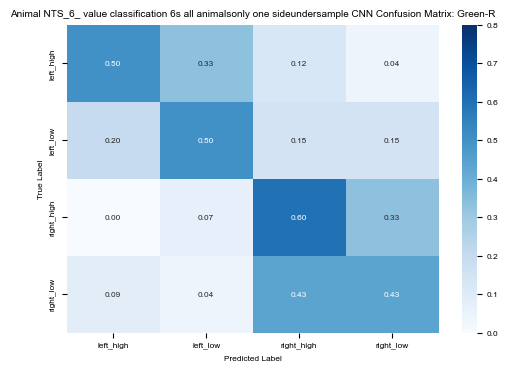

<function accuracy_score at 0x7d6aab314ca0>


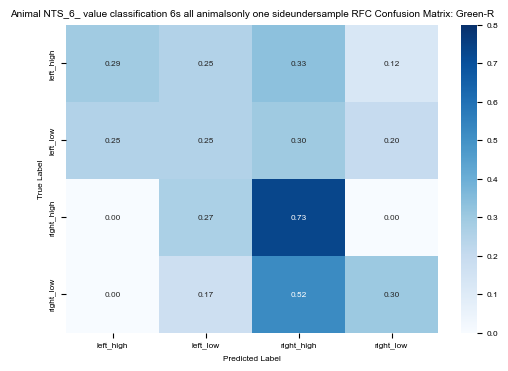

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


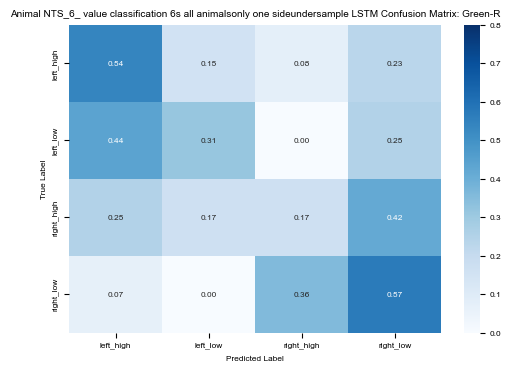


 50%|█████     | 2/4 [01:27<01:28, 44.01s/it]

X shape: (272, 60)
y shape: (272,)
2
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


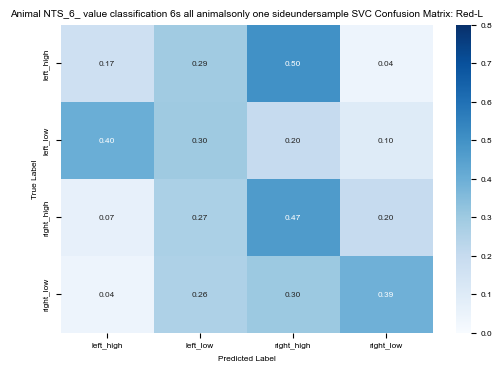

<function accuracy_score at 0x7d6aab314ca0>


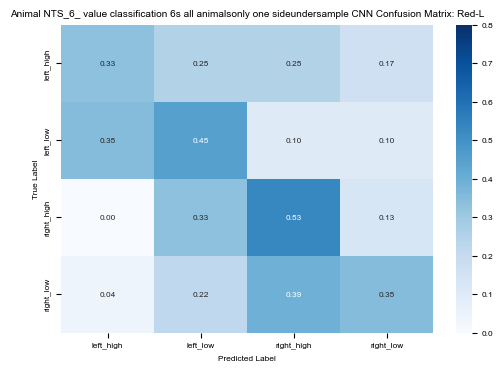

<function accuracy_score at 0x7d6aab314ca0>


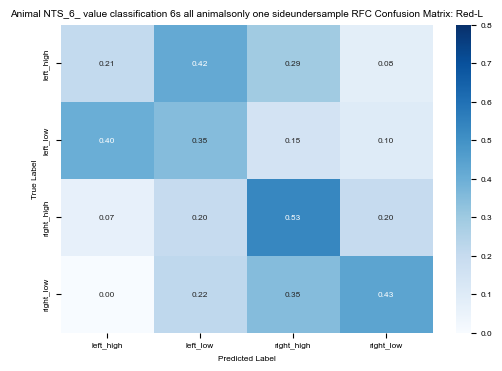

2/2 [==============================] - 1s 6ms/step
<function accuracy_score at 0x7d6aab314ca0>


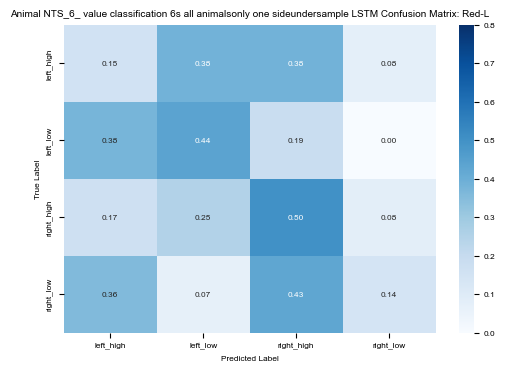


 75%|███████▌  | 3/4 [02:17<00:46, 46.85s/it]

X shape: (272, 60)
y shape: (272,)
3
3/3 [==============================] - 0s 3ms/step
<function accuracy_score at 0x7d6aab314ca0>


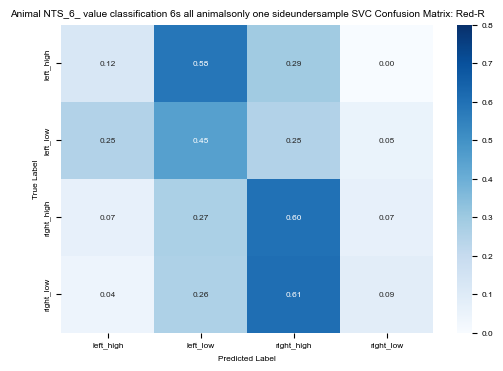

<function accuracy_score at 0x7d6aab314ca0>


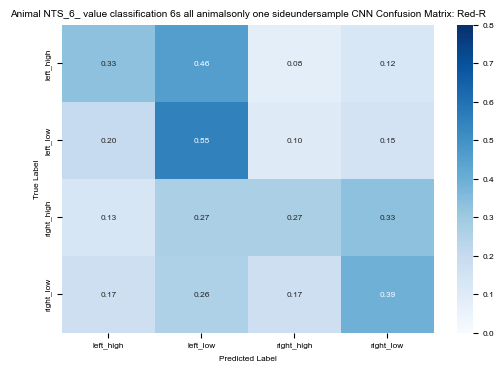

<function accuracy_score at 0x7d6aab314ca0>


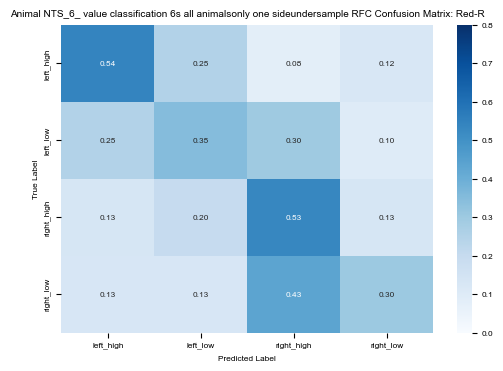

2/2 [==============================] - 1s 7ms/step
<function accuracy_score at 0x7d6aab314ca0>


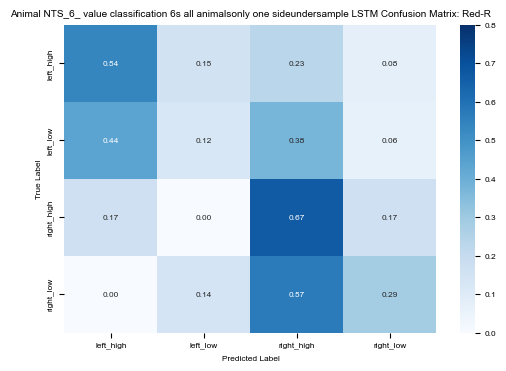


100%|██████████| 4/4 [26:33<00:00, 398.36s/it]


In [ ]:
data_path = "/content/drive/MyDrive/Dopamine-Astrocyte-Behavior/Pkl_files_for_SVM/240523_event_by_event_6s"
animal_types = ["PNOC", "NTS"]
task = "value classification 6s all animals"
today = datetime.today().strftime('%y%m%d')

print(today, task)
for animal_type in animal_types:
    if animal_type == "PNOC":
        animal_numbers = [1,2,3,4,5]
    elif animal_type == "NTS":
        animal_numbers = [2,3,5,6]
    for animal_number in tqdm(animal_numbers):
        animal_for_this_code = animal_type + "_" +str(animal_number) + "_"
        print(animal_for_this_code)

        file_paths = sorted(os.listdir(data_path))
        files_ = []
        for file in sorted(file_paths):
            if animal_for_this_code in file:
                files_.append(file)

        lists = ["left_high","left_low", "right_high", "right_low"]
        labels = lists
        all_necessary_dfs = []
        for list_ in lists:
            concat_all = pd.DataFrame()
            #labels.append(list_[:-5])
            len_files = 0
            for file_ in tqdm(files_):
                if list_ in file_ and "(1)" not in file_ and " 2 " not in file_:
                    concat_all = pd.concat([concat_all, pd.read_pickle(os.path.join(data_path, file_))], axis =1)
                    len_files+=1
            all_necessary_dfs.append(concat_all)

        for idx, df in enumerate(all_necessary_dfs):
            if idx <=1:
              all_necessary_dfs[idx] = df.loc[:, df.iloc[-1] < 0]
            if idx >=2:
              all_necessary_dfs[idx] = df.loc[:, df.iloc[-1] > 0]

        run_all_for_each_animal(animal_for_this_code,task=task, all_necessary_dfs=all_necessary_dfs)